In [6]:
import base64
import torch
from fastapi import FastAPI
from pydantic import BaseModel
from PIL import Image
from io import BytesIO
import torchvision.transforms.v2 as transforms
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from ultralytics import YOLO
import cv2
import numpy as np

In [5]:
def base64_to_image(base64_string):
    if "data:image" in base64_string:
        base64_string = base64_string.split(",")[1]
    image_bytes = base64.b64decode(base64_string)
    image = Image.open(BytesIO(image_bytes)).convert('RGB')
    return image

In [4]:
def predict_MobileNet(image_tensor):
    # Initialize the model
    model = models.mobilenet_v3_large()
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, 5)
    model.load_state_dict(torch.load("model/mobilenet_casia_web_face_augmentation/model_MobileNetV3_Greyscal_Augment.pt", map_location=torch.device('cpu')), strict=False)
    model.eval()

    # Initialize and fit the LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(['Oblong', 'Round', 'Oval', 'Heart', 'Square'])
    model.eval()
    
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0)
        outputs = model(image_tensor)
        
        # Apply softmax to get confidence scores
        confidences = F.softmax(outputs, dim=1)
        
        # Get the predicted class index
        predicted_class_index = torch.argmax(confidences, dim=1).item()
        
        # Get the corresponding class label
        predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
        
        # Convert confidences to a list and squeeze the extra dimension
        confidence_scores = confidences.squeeze().tolist()
        
        # Get the list of class labels
        class_labels = label_encoder.classes_
        
        # Create a dictionary that maps class labels to confidence scores
        confidence_mapping = {label: score for label, score in zip(class_labels, confidence_scores)}
        
    return predicted_class_label, confidence_mapping

In [3]:
def face_crop(image):
    model = YOLO('model/face_crop/yolov8l-face (1).pt')
    
    desired_size = (190, 250)
    padding_factor = 0.1

    results = model.predict(image, show=False)
    boxes = results[0].boxes.xyxy.cpu().tolist()

    if boxes:
        box = boxes[0]

        # Calculate padding
        width = box[2] - box[0]
        height = box[3] - box[1]
        pad_w = width * padding_factor
        pad_h = height * padding_factor

        # Adjust the bounding box with padding
        x1 = max(0, int(box[0] - pad_w))
        y1 = max(0, int(box[1] - pad_h))
        x2 = min(image.width, int(box[2] + pad_w))
        y2 = min(image.height, int(box[3] + pad_h))

        # Crop the object from the image
        crop_obj = image.crop((x1, y1, x2, y2))

        # Resize the cropped object to the desired size
        crop_obj_resized = crop_obj.resize(desired_size)
        
        return crop_obj_resized
    else:
        print("No objects detected")
    
    return None

In [83]:
image = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAL4AAAD6CAIAAACQ32qwAAAgAElEQVR4AYzBS69ue3re5d/9/Md452Ed5lznqtq14yobxaIR6IDoBdFA4aAgEAIESDQQTQROAg5BHCQaQQTZyEGiCx8C8QFoBkMDhAAjkByXq/bea6/zmmvO+Y7x3Dfjfefau2xHxL4u/fW/+Jenabq4/+DhgwdPHl4+e3g5a3hZ0p6maZ7nlFJayT69j7vo4uuXL3/xzVdvP3y4WfeLezo5GScnNU1M082yf/vh/buPH/bruqxLt9N2u7tt78Y8j3nt3q/L6jaYUKKKoIQjQR0hASYNraANY4y5pkkKJnEcZ+OjHDmJ7YR8B6pqVEkKn4nPkgA5AiQhRJVKqkBAnxVVUukoB7bj2Al3hBASCUeSsnFit9tt4tgiIIGCIN9rJyGBnEzzyTTPVZNUIfu998u9eb6/O728f//pxaOnl4+eXT569ujR+cnp2Xwy1yinwlANVYEQjrtjxyGRVFXaIITb7QYkAQLxp9Bf/4t/eZ7mi4cPLh48fPLw8smDi11NXlbsGjVquLC0koW+TV+vy82y//bt629fv766/rTErexOz3anZy41fLq9ef3+3duP79fupdvtdLvttpNJY9RY175d921TikSJkpASQCBUVToKBFppgoQ0SlONIZGN8z3HcRKCyR1yxIGkkjgKiD8pCZBEEqANhSoc6TNUOihJgSQkjp1wEBAbCRAHQjmw2+6NSScWCAkJBDly4m7bEpu5xm5MkzTQCOpm7dMxzqb5wenZ5b37l/cfPru8fHp5+eDs3r2zs7PpZK6aNSZpqBRIlJDgEMRGAkmAJB9xpA2IP4X+g3/8n5un+dHlxeXF5eP7Dx8/uNiNwerYgcCKm6xkUW56+fbdm2/fvrm6vv50c726NY3azef3Hpzfv3+7rp/2t+8+fvj27es379856cR2OrbjxCYi7Jfldtk7GbtpzLMkJHEgVCCQVCo2wtBKCwHaMJDYhHwGJOEohPD3yh1C+CUhJDZCJOFOEoQEQgTxmTZUSSoVkiCQBMh3ONIdJEjiJN3r2l7XxIkFkkolUSjESdtrr23roCpUMtCAIc3SpBrJcHaq05rO55MnFxdPHl48fnjx+OLy4b37909P752cTmiosLNayaQaVYWKIhsTNpLsBBO0AW34U+hv/BP//G6eHz969Pjy8uL8/sX5g900VSBZel3Wvl2X23XZZ93H1728evf29fu3N/v9fl1q1Mn5+cnZ2ZjnaT75dHvz4frTu6sPr9+/e/fxIyLQjttxyFHH9tq9X9coY57HNCGQhCQKCQoJBIKIQAsrQUBJJZUgbJIAIYAQd4QQ3xObOLazIYQ7OkIIATnyJo6TEFCVhhISCBGIUkklVZU2IP643HEkhEgcx+613Z2EWEclCQkcd9Lx2t0JR0oUKikYaB5jriqnuoeZwk7j4fn5w/PzRw8uHj18+PjBxeOHDy/vPzidd6fTXElWVzJUEzVUQ1KIQ6IN5IiNJBBI4u9L/9E/+S/udrvHl4+ePHp07+Ts/snpybSbxxC6vr25vr35eP3pw6erq/3t9bq/XpdbL/t1vV32t8t+3p1cPLo8u3fv6tP1x0/XVzfXV9fXH2+vP97cXO/3FJHc7rYdcWA7diAiUiSKTVCJQoWECkSUABEBC4tAYFRNNVUVn4XPJLERQoDEQbiTP4pwR5sSSGLTbbvXtXtd1253OxnTNOYpiZM4B0QqqUZVjfqeVFKVDmzvD5ZCJUEgid2OAwF0B0hIOl5tJxZOemOXVFIFgZKBBhowwYQGzNKuxskY57vTe7uTxw8ufvDk2YvHTy7uP7i8f39WlSNHnXKGNFQDFSokkBQ7CRtJgBDi70v/yV/6l3a73bMnT54+fnIy5pMxDUTi9vXtzfXt7cfrTx+vP13tbz6t+1uvmgbTAEJqmnYnJxrj7bv3b96++3R7e72/vellby+2ScS69rKsdiQB2dgaVWOoyoohbCJUUqEBhYhx2IhAhKWQkKoxjalq8EsBcSR+KUAChCSQANmQhI1Amyp9ho967bXXXrvdtmtMNSpgO3Y2IHRQB6O+N9UdVezb/X5/uy8hBAkhdoLDRghtEDixO17tAFWBpde1VyEhERLBVDWpKgyopJIKszRLO9VO4+HZveePHj9/9OTZo8fPHz26tzs9necdpbbaFQ2YqEljSAKBc8D3JPGn0H/6l/7l05OTF8+ePX/2fIQy+5vb66ur65vr23Xd93KzLLfr/qbXW6+Lsjs9mU9Pzs4P1nV99/7Du/fv377/8O79h9teF3cLV7m0ulf3fllub5duSyCRDWMa827WGBERJgmSBioYUgE2DneEpYiAiVSjhlR8FoVA2IQgcBISZ0PixIlAgmCSIBCopPpMVRz5KD7KAZDEOSAHkgAdlJCqSqoaVaOqhkRY+4A7sePEORJIQhIHie103DZSjYmqtXvp1XYc4iQlTubdyTxjp51es7bcuzGdjDEcrT4d88XZ+eW9+z98+vxHT58/vbx88uDhvd3p6IwOtjqztNMYKnFgxzFHkvgz0H/2T/0rpyenL54//8Hz596vvV+ur67ev39/dXW173Xf3UpDhjyV5rE7O92dntYYo+rTp+tvX796/ebtx0+fPl59WuImXWIMj1rWdellv677/dq2JAQIGNOY5rlGpRTJZFOopCEVFGDTgQCSUqJk4gDagEAIBRIgEBAoMThOwM6GOBESgjgJIShQoFKpVCqJjSABwlG8aRMHSMJGHImN+E6ppFKpVNqgTY4cx+04iRMJJAESZEPSieMgUUGLe3UDCiGJgXma5mnCsZvuuGXPVXPV6NTqmTqtcT7vnl5cPrt49INHT148efrk/sMHu9N780l11B6mwgglleQQgviz09/8Z/6105OTF8+fP3/2fP/p+vbq+urjhw/vP1xdXd32ul8X7abazfPZ6emDeyf3zuaTk/lk9+7du9ev37x79+7Dx48frq5u9svNsqxJgwuXutiv635dVrs7BgnQQUlVGqUqRlGV2ElJQxpQUChtbIiAkkZR5aQhARM22pCIg0iAQBDIBkgIISEEoZCNE5wDAoRNCEhA6aiqpBK20w4RIYBAfCeBxDkAEiQQo8Y87+Z558/a7o6TOEFIHEjcSQIh3en22m5329NmN0u07TR3AqRgwABsxVOYU5MZ9uScT7vzsXvx6PEXT5//6OnzL568+MGjJ5OZgvdr3+zVnsaYx0SBQAJC+DPQ7/wL/+bJbvf0ydOnT558ev/h47v3n66urq9vbvd7jWJUnczjZB6nJ9PZSe3mTtb45cuXX3/99bv3H273+9tlWe3FXpM1WZMFr3jpdemOQIUIB3UwkCKoYoiq2E4KjdJAgoK04xZIqEqjVGXoxI47GxBHCgcCBAjCnRACJOF7AUIIOSBxEiexw4FKpRpVY4wq4RCTkLCJOJBEwiaJ80tARNWYp3med+2jOG4nIQGJA4EE4SgctOPV69pr99rrNM/TPKvk2DEQIAkpMdCAuLEnNEWTqe7qzGE2T+4/fHbx6Isnz37lxY9+/PTF+bQ7n3ZqZ7/ImWuaqlSSQAQImxD+iPAn6b/7V//t3by7vLx8dHH59vWbd69e39zctFtV5w/vnz94ULtJu7mLffp6Xd5+eP/2w4eX3377zcuXV9fXkQKRghb7tnvf603v97123PGYpjFPVeVsGEdBTQKUKHmTFAxVodKGdKcbqJKqagyNcuKk27262/z/ExA2SYAQwh0JlTYgoWxw292+k7gOxqga0xhVBUU2OHESNkJIYiPAJJA7bIJUGlXVjpMQEsSBgg4Qf1REgEBwZ79ZltpMAykEoSqpghOTCAqUKFEoewpTNMJYuxbf251cnJw9e3j546cvfvzk2eP7D5/cf3gypoma0EQNSURsQtgEEEmAcBD+JP33/9Z/OMa4d3a+ufrw8dPHj8uyGDTq9N69k3vn2k3sppte3l1fvb36+PLN629ev3797u2bd29v9nvGoEoqqvbdt+u6X9d9L4vXKIExjTFNlAiBGmPUcOLEoBKlHAkVVVLpIHbcAnSANpg42NnY5A4hQNiE74QAISQBknAkoU2pVEIIiBM7PmjbSKW6M0olCpHEjgNKqCodFBIiISSOk7BJQAhkSMJGHAiExJ0QxEYSEElIKM5+WZb9gjiQ2EhjjBojhDhHJAKSSpQMNKmmwLKyX05rOh/zxen5swcPnz24fPH4yYtHTx6end8/OTub5lljphTLEVGA2HGMhEACAjmSBAj0d37jvxCMGqPKzsbEiYWrMirzyG76eHv98t2bb96+/urVq69fv/pwffXx5nrvjpQqaVBjv663637t7rSTGlIJiZIE2iCVVE6cBFQlFQcRpQ2qUkkESEISEsdJnBik2qDynSQ2JGEjQkLCJhsnQBIgBAFCoqqkUSUVQglJfLAmJJJQqYRQSTiJCUFS3VGVqkBJHMfYCTngIBEiArRBQFASQkhCELpTKhWSIKHXXte23d0QHdSYxjQmxCaJ246TkAgKhjRVFcp+8e1+Ric1zmqcj/nBfPKjZy++ePbi6cXl04uLh2f3zsZ8WlOtre4RCmKvm26N0ihVSRWwu9ulA4T+t7/yWxIgASWkTjpek1WssA669Ob641evvv36zauX799+++7t9brc9LrGlozaWZ3VvfRqm41So2oIEUAbKERJCjjhoITuIInSBoRCNiSBHDgbkkAVKsB3ktgkIQQRAQmbhCSEgxBIAAmVSiVVlaoE4igHTiCEABICIXKHsFFJqpJKVUgJEDsJzhEbAREghCQQSkgIIQQCVJWkGrXhKEm3u+110yQglaYxTWNCIMVpt+2wiUBCoCBQW/YcZjSHqb1LvXjy5AePnz5/9Pj548dPHlxcnJ4/PD0fS4+1hzOApNttU6J0B6nbdleV7vwf/+5vIbQpGQyrve91n26ppVv3TdZXH9//4auXX7959fb66t311UJW0ciinevb/fXt3rHZpEqbGqoSAoHYSKADJKJATKCqRg2phED5zHYgQEAEEQgEnNhxHMd2bBIOIpBQ2CgBFFAgBBKkKiSVSiUhCSQhhCTuZEM2RBzlDs6Gz1SSUAkhEkIcHO5ICkSANiCUECAJGyGpSiXV2FQgie223d1L99pxAEnTmKaaIhBOvEmAgIQgca+r7d0YJ9M0YDJaO7f7WvrxgweP7j98/vjxi8ePXzx68uLy8bOHl9PieenhVCgQIDlxHB0AOZJUVdr8X7/x2wgkpE6arPY+vcT7eB9/uL35cHP98v3bX7x+9fL920/r7ad135JHtWRY7U83N5+ubwMqbapUJRVVIJAQG4kghNAmUQ4YY1SNUkmV4O/kCJBAoAAJTtqb2M7GTkIiQBQqsREIBAIUFAGhpKpSqXRACAFJSCrVBggkdtux2AhCSOJg5w4ICZUOKhDikAMQQoGIgKgISEgI4Y6kKlWpqjSGhEMSt+1e1/bStgmIUWOqKRCRxDkChEoSsdd16e6TeT6dZiVqa121X6v7/u703snpo/v3Hz18+OLy8Y+f/eCLJ8/ONc4ZcxihUJVK1Xa72UiCHFWVDtDv/dX/KiIoouPVWUkrS/xpXa7W/ev37199ePfy7duv3755/fHDqiyyR2UMi4bFvr6+ub6+oapGHakKhBQkShIbiYQgCaEgQmAcTFKJSmK7u32URBIgBZEN2F67vUnikJAIJAQllUpCQkIgUCFFSKhKVWNUCSTZjh2QVNI4AgK2e+12C7ThIKETOz4CBUlVJakCASdOYhCbQEgQKBASHCABEiRUVZJGbSShSvBRr2svq+0kQGkMFVIgxDlAQtSQqhKvy+p13c3zbp5Y28ui7inMYVbtqs6m+d7u5NnF5U9+9OOf/OCLRydnj07PTzQmM6gxarP2AYlAkATQHdDv/Xu/EzBxssRrbClT7eO3n67efbr6+s3rr9+8fv3h3Zurq4+3Nz3oIUstNelktffLcrtfq1RjVImNAglRqUbpAImEBAQIBAJV1ahCJZRgu7sT29lwFAyxncR2EueABFAiqaQSpaqShERJgpJUSJQOqmpUjRriwEckOhpHQMDt7rW72YQDQeKQxI4TDsRGJSkQ1I7jhHAQyAYBgZCQQBLIBpBKR1SpNgMpPujNsvooydAoVSAiG0hCCVFj1KiQXld3z2PMY3hde78v56TGSY0pDDLCFB6e3/vy2YsfP3vxo4vHP7x4fG8+Oakx1yipJB8pCAQkJJIAgf7v3/zbhk4v9posdqbSPO/Jyzevv3n75ufffvPzVy/ffrq6Xpdbd6by0JqsyWqvdidO2qmqMQpyx7HjGjWmMYaOSHAIkAipSiqpJAGJCLazsZ0DgrHdjt1tmwQQnwmESqrSKFVpVEmoKKlQSVWSKKlKVTWNUVUc2Y6dRGhTm2kQSGz3UXzARgKSEEISwh0FggIJ7Tg4CRtlA+GzEEM25HsgNjoam0ljxE7Sa/e6tjttJ6UqKhASyAYopTQ20wTpXu0eVVOpl7X3ywjnu5OzaR5O2V6W9fb2pMbzi0cvLh/99MWPfvXFF5fn9+/Nu5NpqiAgCAQCBRIlJAob/Z+/+bdDVnuNF7KSVXTpel1+/vLlz7/95pu3r795++Zqf7uIlrpwsdpLsnav7raDQFU1hgAn3sR216gxjTGqSqrKZxxJKlHhswRCEkJiJ/Emju2223ZiSEkCcVBSSVU1SmPUKI0qlUpIGqqSqpBUUpVKGjVGCbHJxoGABKpSSSEQfxbbOeCPEVLCxomDHScOzgYHByeBkIRNQkRIQojjHBEFkJBqMyaNSkjidne7bbedQkKBkEDAgKCkqjFGoL3aPZWmKpx0V9jVmFUDRsi69H4/hQcnpw9Pzn76/Ic/ef6j5xePntx/eP/0rKDQkEqqoKAgUoFEAaL//d//ncAar3gVC9y6b7y8v/70B19/9Xe//sWbjx/efPy4jzVPmaY1XvFqt7O6l167LZVqozEq0G7b7YMxNKYxRtUYVZUjfqlA+Z7Fd+Js3Ac+6E6TA4khJAQlqmpUjaoxaqoao0ZJpdKmRqlUJUqUpKJUQ6oqCfG9EA4EEkEQ8j0S54CAAJVKVQkJdpZ2bxLbQSCHttsxMUlISNhEZEM2TuIEghAglVRDVZFAbrvd7U0cgSDEEHAIICgooQrubrvnaUxjDGlISlib9qSaJNnqVvdo76Ivnzz/c4+ff/H0+RfPXjx68HCiBprHmEdVwCmnqCFhkwj0v/613w60aGUPC/mwv3nz8cO3H979/OU3f/jym4/7m6v9voXmKWMs7sVtCLS99rrapZJqjKpRAhMndttWqUo16kAKkARxFESwkzghgSAO7MTubrvtJgkpoQ0REZQoMUaNGptp1DRqM2ojiSoNVamqKKlKQyodlNABGyFIAiQBwh8nAUocJ4QIIZWqEhK6vay99tpO2yCpglZ7bTsxsWPHSSCJE5M/QgEEEipqqCoIKY47/o5AIRBicAggIgJRTGInHnUwjZpHKXhZs/YkDWlAQdm1rGP1k7MHT88f/Pj5i5/88IsXj56czruzabcbYzcmOawtZ1KNkoISgf6X3/gvkXrIQ7fxPnn14f3PX738xauXX715/fWb1/t4xa5ijJT2vd72qiqNkWRd226pjsYYpRIixHY2RAKpSht+SQkJSWzHTggiCAjd7U23vZIgShqjplEicSuuUknTGNMYo2qaxjRGVY2hKkmUNFSbIao0qkZVSSKADtAGscmBHcccCVRIqlGjRuK244AIqkIKxOnuZen9utpuB0k1gla77XZst706tttx7MSOsyEkAYIESo1UoVIVqjh20m47iYIgxOCQxBBA6ti0E45EEPM05mkq4WXNuhYaaKqaRo2E/Vr79Yxxxvjy+Yt/4Ms/98WzFxfn9x+e3zsZ08mY1Ml+VXuqmqsKBAL97m/8rUhd8tDH/f7jcvvNuzc/++brX7z+9s3VxzdXH1eyCksuWSzuxV01VAOwHVIqlapqlKSiuJMNgUQIJHGgHJAjO5+ZBBJCQty2k44NqQPNo6ZpFCGtpEolpjFNY0xjTKPGgepAQyqpSkNVpZLGqKlKAkIiARIUB4FsbCckbIQOqCMnsXMAaIPkJE63l3Vdu9uxg0pVqDo4abvbq722V3/WSTtO4oQkhIAiRRVVVFQhxcSxHTsOIBRiSOLESRCi444jJAGJE49RU9UoVRCRQzJU06gRau1aPa+ZOy8uH3/54gdfPH3+7NHjZ5ePz6b5bJqrw9LVnqRZVSAQ6O/8xt8KdGktvfn08dWnq1+8/vZnX//iqzevPq3Lp3W/ikarsoYmTTquGqWhA0BVUklCUpWkqhJHIY4hgKQEkI+S2PklE4eQO+7EJJCSxqgxah41jypFRKSkIaZpGmNMY0xjTKOqNEpVNaSSRh1JozRGTVVSNiSQBEGxCZAjJyThQCAJHSROnAQEQkLyUbfX7nV1wAFtiqpQQavd7bV7v/bqg7bbbttJHJuQQFDAKktBVFEVx06ctElAoBBDEm+SAKITx5E0SlL36m4pJcYYJ9M0T5PX9tolRmmg4QxT+679enl27/nF5Q+ePP3yxY9+/OKH93a783k3GS092hOaUUFxoP/pr/2Wkz3Z46/evP7F21e/eP3qqzevXn18v4pF3Lpv3WvcwQKJgohoM8aoKhUlhWx0VKU7kBA2QlJCgu0+cL7nxJvE2ZCQgAUlVWmMGlXT0Cim0hCTqFJJ0xjTNDbTGNOoUo1SSaNUpVEbDdUobUoSCSYhBwIBQhwkkIRNOBAH2UAgYSMQKOAkTsdu23EIBFBFChXU9tpe7XXt1W7biZ22ndg4nxlZ6rAGA1Wo4sSxHScOiKOAEzuOw4FJICLiTjAJSZV28zSP4bU3Q5rGKNDaak+dqTmr6d68e/rw8le//JWffvHlw7OzhydnJ9Roj84UTaFgcKDf/c3f6fi6l+tefv/rr37/659/9fbNq4/vP9zecLLTbr5abj/d3uzdkZDGGDUNd9wuaZrmaZokVNjuboik+g4KG6ENCiSsR92dkI0TH3Q7dmIcSSVKGlVjaFRNo6RI2VWdTDWPqlKVpqppjGl8R6rSEFU1SqNUpVE1VCJADgwhIeZISKIk/h5J7LaNEEICISUBHJI4G3JAwBAICmXUdrdXe+1uu40TJw52nNhx4mAwLMnSXg1VVMWJ7Y6dOICkBJATx84RIEAmjk3GZipv1paYpzHV6F67e6qapqnA+yXLcqJxwqi1uV0vzu//+q/+2p//ya8+Pr//6N6DsxpzmE05wwyYQKDf/Rv/9er+cHvz/vb6//35z/6fP/zZtx/eftjfXvfiaXgat+7bXtYkgJBKJUJMqaZxgEC5gyhJtVGpUEKAHJADbPeBD9rxQbwJsRBkSFUapTFqqprGmEaNooZ2VbuhedQoVdU0ahp1MMaQShqipCqVVKUhVakkEcKBIgIRkBA2EmIjiQNJfOYjDhJIMOQOJGwSIA4JhgSjhKBOHNpenW633U4nThwSHJI4GBpWZ++sjiHgjp3YcRLuBBIcbGdDDJKQEEgIHWC72yJjVElxx5ZUqgJstadoCsMMcz7tnl1cPru4/NUvvvy1L758sDuZOpMzmcmapEkq0P/8H/83+3V9ffXh9dWH3/uD3/+9v/v7bz59WMheWcQiWjRYhABJAFGlKtWoKikkijZIJZVU2lRV4hz4O7FzRNy9uo9sxyaIlKpKU2kqjaFp1BhjHmOexjTVNMY8NIt5aIwao6YxRm10p2CIQlWUNpQkKCEOClTogBIkOAkQQEeADjhSjpzESdyxEzuJgzgQRw4OCU4cAgmGSO3YrM7avbY7sR0ICnIIOHFYksXsnXZW22137gAJGycxzmcmAUmUqmqMUVVO/J0kJSRIIBucgqEaKrrp7FQnY54Dt8tY+x/5C//wP/oX/qFH5/dr7Wn1HM3RXDWrStL/+Ju/fbPff/329VdvX//s229+9vKb9zef9spCFrGQlViY74hNUVIN1YEUYqwqSVVSaQNISpzYSXwndjY+6rXdjpNYQChRUompNEZNU81jzNOYpzFP0zRqmmouzaWpNEqjNEaNKh0gKFFQUoGkKgpBBCUkSgdV6E5CDtgECSRA/FIg5MBx4tjOZxyEg0CCQxJnQ1CiSBEdbNpe2+vanbSTEBRIMHTSYXH27cVendV2xwcBEggJDs4fgQIIbarGpqoTx3dISkgkkI2TKCnVkOjgzKpdTRNov47Vv/6Tn/75X/nJDy+fPL53/+HJ2RzmaDiViOh/+Hf+5vXtzR+8/PpnL7969fHj66sPV+v+NlnIghfSpJXwmY5KVYyqGqoqOTZWSbXRnSRA4sSbHLnT/k67u90WCAoklVRQYgxNQ/M0zdPYzdNunnbzNA1NVVNpLk1SFaOoje6wKVIgUahE6YBEpERJVdpUqaSqIiEOkHAkiSQcJGEjkJLYSWyTxLkDJBxE2PmeEShUpEgOTuysa6/dbdpxCArkgDVZk8W+Xb1vr/bq2PFBNoREiZw4dgghBIE4kjTGqDGcON4kIZEokc+co0IbHJlJNVdN0WgP8+Ly0YvLRz998aNf++LLH14+nmGOsqwsC4n+23/9r17vb3/+7cs/fPXy43J7texvvO7JPl7JElu0EhBC6KhUpSrV0IGJY1XVKH2GYzuO43ZMSOJNe9PdbruddlUNqaqGVKWCEmNoGtpN026edvO0m6fdPEbVNJiqdlVTqYpSSpsSSIgICqooJFGSOEqqNIRKpYPSAUGYOwkSnyUhGyIJKUdOYuwE5wgIhCTkgGxIQqigVIEMDnbW3ridNg6BBCcOnXSyb9+u6+3qNWmnnbbjOE6IcbDjbEhIiAjiqKQ6MklInAQobcgBthMnEQIERAMGGmF0ZnNxdvbw5PwnP/jhr/+5X/nx0+fn03w+zdWuNon+83/637jd3/7izeuvXr9axCL28hLv8ZqsiXwfUxgAACAASURBVBWLgL5TVZIKlVQqCSdOajOGShx1ur1pu3MEuDtt94Hb6cSZxsE0aqoa2iCYh6aheZ5OdvNuN51M024eozRK89Bu1FRVSgmBECAFGKKghKQSQmIToKQqSkfoMwIRvyQpCZDvUFJVjuzESUhsDCQB8hkJIRuzqaCoKCUK2FntbrfTjk2CgxOHTuzsu2/W9bZ7dVbTdjs+itPBxs7GISEhEIkjbUqlSsJREkSpJOXIR0n4TKKUEA9nsuZwQp2ofuXFD//Bn/70Jz/44cXp+cXZ+RSmUKC/8o/9s/u13376+O76ak/2ykIWvJI1aYiwUOmPQQcgJBEOVKoqJESSjo/a3Y5zp33Q7e44CkRT1RhjGjVXjVElhpiGplG7aezmaTdPu3nM0xilqZhG7UZNowpESkeAEClRopBESQJJHKRE/X9swduuLel5JNaI+P6cu3jQkWpRapCUSKqKOpEUW2oYNmAYhmH41tf9/u+gvWb+EeHMufaqKtoegxcQvOFGFCgAEgDf4VIUvQAoCbLfFxRpU7RFP6AXFOgFDICyFMSCLdruNIkDB20TpHWb1EXap/22/bR36tbpdp3EceLUudRpixQtCxTEC0GKBPF9hCiSRQE0TdILWlwIsCliBUf5AB/QJ+qnf/bnP//rn/7sv/z1f/3Lv/rbn/zVSqdVwf/xzf+c9rPPz95P9A050c0aCGoAZEWKfwQgiA8kIb4DUSDNBydO0lvi1GluKASyXKORjpk1OkYjjnCMlvRYOtY8jjnWrDVLGHItPUZrREAASfFdCYggIYCkCII3FAQJEgRIAmBBXHohyheJpPChF6BkwbYA+p206Q29pR8AtCyQogAokAVRpEjrNkGKpE5TJHHr1umZPHdOx81u7W7H7na27WTbTp2mbViwRUF8hxcAJAGQBCCJJF76kjZt0YIA68Rm+uA8oAf4ifzTr37wkx/9+G/+4if/8PNf/Ppnv5hkXAH8v//+3wuczNk+kbdmo2YNBDALEuJFEr8FEt9DUihuBYq2aNM2ceJ8aNIULVoCgoYaccg1OmbW6Bgdo2N0DNfoWDpGa2mN1miJS1yjEQWIEEmJhEiiuBACCJAQ+AISBAiQIG4EiHcFIb6TRIAgUBQoLixQIL2hLYpe0hZpmrZp0Bdc2CK9gQJUoEABpykSJEjrNKkbp07d7vS0T9etG7uns53T3o7tbTt16jZlihYoi1tBFC8EwO+BeAMBFG1RNEWLAHUuUzw0nziTrPQHs358fPrpn//FP/3y1//4q18tRylb/l8/+23JiBk942ezUaMmSoQAX0RJJCWRBMDi0hYARYpp00uKW1sAiRPHcZykCVICJEUONdSQIg5pjY41j7Uea47hY7iGa7SkNZzhMVqjEYccUawI3XgDSbQFQJQoQfEmQSQL4kYWAC94V76IpG4gCQLoBShYsm16QwG0TVs0Tds0SdMXXMgWaZKCBASgYIq0KRKkTeDUiVMnTndrdye7Tep2O+fOaZ/2aW9nb7t16tZFihYNChRsgaLFC78FieL3FWjRwq3TWzLFp1mfZnBubj+KR/Vf/vTPfvvNN7/9+puVTiqA/+ff/T6AiY1u9GwMhAhbogBE8CaJpCS+w63FjQCRJmmaAmjx0iS14zi2WaAVKXKo0YwkYIA1PGaOpU9rPY55jI6lJY6whktaozVawxGHEClBhC58BwJF0aJFS4CkSIkkCBIgQZCESIoESAIgRUEUXwAC6AUoWKptWjQF0KIt0qSXODcDaAuCYIG+A1sUbFEgRYoEaZ06TbodJzt1YncnO02b4LS3c9qnfdrb3clO3bp1kKJtihYpWiRtWgDlTQIvACmJIimSIFoWSJGiLVIBC1ygbDlHepR/+cMfff13f/f1L37xFz/68V/86MfHLP4fv/xD0LM5G6ObCFAiBIgC4Iv4Ti+8gCDaAihaIh/6ghvRpEl8SSKAhaiRRhrNSAOoXaNj6bHmq2M+rTnWHEtLHHWJa2ZJazijEYYQQYKiKJEiQZBA0ha9hABBERQlEhD4ThdS4rcAkuALwEuBvoBTqGibougNaJs2yM3eifHCCwCyXyBFgJYtArRI4DapUzvbseNkp05Ox2nSFNs57dM+7dPZ6U7cunXg1kGK9IK0Se0maYESJCWQIAhSoqgXkAUBpmhxa1kwkTvtale63D/59NXP//qnP//pX//ip3/787/5mx9++or/+6/+kPZZP2sDQUOWgIgLb+AFvIiiKJEgWOLSNm3RfNE2veDSlzTpJRVBcMihRpqZJQ055DE6Ro+lT2sea9ZwjZawBks8ZpY0wxmOOOQIvEGgKBIgSKBF27QIAZIiRIoUbyIpiqIofgGAJAC+AASBorgVKlQkLZoC6CVAm7SJnTgxigsJkiCAtkgRoEGKpgFatEyR1ond7Uuc2NnuTrabNu3pbPt0Tvt0znS3Lty6cOA2adqkKZzasVMAJUiQ+EAJpC4jUgUBAizJ4pb0NLYf4kNaqXa+0vzkxz/+yZ/8yTd//8tv/u6Xf/LDH/F/+/Uf3D67n7FbAyAgQfw+ECRB6AUXEmiBtGma5tI0Tdu06EvQoC1uA4oUOdRIa+ZYWtKSjtFj5hg9Ro/RCCOuwTFcozVa0ogzGGnpQhIEBPALkECLAk1RAOIFQ4oUKYmkRImk+AUA4oUvuBEvBQoVbJumKFoAbdq0adL4khgFARIQSbxLmyJpghYpWhQomNZpnO34Fjvb2a5Tp2lP+7R38nTOdKc7NeDWhQsXTuK4SOB029tB0RIESAC9AXyZiygBBAiKlxIXx88z5/5qzVfHGoenV/qDNT9cx2+//uZfv/7Nn/74T/i//sMf3D6z37zduAXJEaWRREG8gOANvEjFrWiLoo7j9EMuvaRpG7REAV6GEClS0Bo91vp0HGt0jB4zx+gYLXGJow67hsdojZa4RiOOOOKaGREoAAIExQtIAiCBFgAJAiIlDklRvEik+AUIFN/iC0iCIEACSFkgbZq2QC9ogVwaJ74kAUqApMQLgJK5NWmC3ligIMikSZ3Y3r40zna2s920aU/ndLZzxqezi124NbALp26d7jRBC6fn9t4u0AIgwKJp04IX3WYo4UZShAgQQBq79iEdohKdHvcT8Yn69c9+/uuf/eJHP/gB/5ev/5Dmzfvp7cQtSI0uM7M4EEFSIImLeCkaoB+S2AbQord8Cw1atqIoDjGkSFHHzKfH8elxPGaONcfoMVriCEMMO+wSj9EazWgNRxxySWtGEpCiBAiQIileQIIkAAEkRIrUhV+IFL9oi6IocSEJ8AuQIAGkSFE0bVogQNGiTZw4juM4QIFK1AsupJ04SdMmAFEQIMC0TZxsX2In6d7ZznbSpj3dnZ7Otk97A7vYhQEXTnfiYKcpWto59z63A7QoiLJtWqcgAHI0M5QAECIpiiAL9BK0Aoalq+1xVnuk//Unf/W3f/lXP/j0if/T1/+W5m3vt32CBMB30lAvpESJAkgQBdKkDfqCvJAUCCBxnPiGlg0KEiSGXOIarZnHWo9jPY51jNboGB3SGg4xwiKGXaNjeMys0TEjccSRhreiQAACEEldOKQoXgASJMSbSPELFAQIguAFBMELAOID8VKiQIECRYsbCbRoE8d2Yjs2UAAkNRJ1oeSXOOkLCLC4JfEl8fa2k6awux27aZPs9Ey3cyY72cVON+DAhVsXDlK4cLt3nuf5PLfTBAUJFkib1mlSipQ0M5qRBBIkbr2gQNEgFTDFKo7iAP780w//7KsfHBr+969/7/a5z7fz1AtJAAQlihqNRhxRhNg2aBrHQRsUTdtU0nCAxo6dbXsjZUuUKIkRh3wc6/FYj7WONceaJa7RIa7REpcwwhKGPIbH6BitWcfMiBqKEkmgaBviRt1GGupGEiRBgqQIgpJI4pLigyRK4gUkcWmLS1EUtxIlSgAEwRvQEvAfwwtJfWvGe9tO0ibFpWBfcrG3v0iRIul27SZNu9Pt7uRMdrKLnbrYhQsHbgumdLvTc/vteb49T7vbAQioZNsU294OCFAzOtY6ZhEgyLYAiKBl41wGWNKiHuABfBV+KlXwP775t7Rv+3zuk+BF/GKk4Wj0DiKEoAUcp3HTNi2KFqIkoqgd29vxZitUAAkShzTS45jjWI81x2itWeIaLvGQ1nCEEZY4wiEdozU6Zh0zEkVKFHgBChQgCVKX0QtFgiAJEXwRbyJxKdoCJEFSFC8CSVxaAAXQggQKokRJXAheQNyaxO/23glaACQl8QVAkl6S9AXot1Ln4ksct2ljOE3q1MFOdrKdnZyp2x3swq0LBy5SBnC6jXP77Tyf597O3mlRIGWBAEntlgAvmtFIAgbgC8iyIXxJWAy5yKM4gEf4CFTw33/zhzTPvZ/7BMBCpF5GM7qNhiIEkEGDpnaSxk1bgCjFG9pu14l3YrUiB5AoYo2OmbXmsWYtHaM1HGkNl3iISxxhCSOu4ZKO0RqtmaWRKHJI8YYXvuhblHgBQBEkRfBFlEgAbfGOEEhKBEkQ/z9IsCBK3HjDhyR+2d7eBtCWoiiSfYeiuPRDkn6RpBfbSZxLkyZw6sDtdnZyOk52soPd7sKtAxcOAqbY7nb3znPv577k3EnqNkXBlgHSFiwuJEFigCFHN4ohQmzbCVuRAo5iFYd7GAL4h2/+Lc0Zn95I0YqcWUtzWTOUxBuIEkXTunGdxs2FlEAABJDWqd2kjcBFjjjCiGvmmDmW1ppjNMKQMxxxiYe4hkMuYQ1HPEZrtEZLWhyJIsTvABAvGkmjG0nxBpLgDXwRJZJgURRgAQi8gRSJbxHEhQBIsGUBlATAF9xq57K37X0B0JYvANom4Qte2ualfyyJ7aROnCZN4NTtdrazk53sZAdOd7sDF24dBHRh99zdzrbP7XP73N7OdhMEKFiwRIoW6Q2NyCFmZs3SqELJvABFoWK1q1juclnw91//vuiOd9y0iahjXWbNWhpKIgEULdsiqBvXbm6NKJFoWTSpUwct2pEOcUkzXOKaOdasmcehEQWIGGGGS1ziEkdcwpLWcEnH4pJGM5QIiQLBC/gykqjLzEikSIJ/DCCJoSQSRFu8q0iCFxAEcSEAEgBJAATQsiALkARAEi9xHF/23t7uBQVAEkCStiQl4aVo0zhp+gKgreM4Tp1L4zpN63Y7dnZyJjvZqdMd7HS3CVy4TLHd7WzXznae289z753TsRsgJcSKaZMmsZNYoIg1cxzHrAWhJIqiF7RsJ512uWuXBX/79W9bBEmbl6GOdTmOmbUWAYJFi14CFHXtJo3jpiJFtUXbpA4SFgKWuGaO0Roda9bMsbRmjqVFkCU64hAzXOISRxxhSUtcozVa0ogjCSApfkcvQ0kzowsFEvx/AUGIFEV8D0uQIAiCJAACIEASFwJkUbC4kAD4AqBt2vi297bdF3xoC4AXACSAtkmapB+A5gsnTp0Lcimc2nGynTPeyU53utOdOnXgIIVBu9tx4HQn5+nn9nn6ub3dFAZLgEzrxo7t2CjYHmsdxzFrcQiJJN61SJTKXelKVfCff/0vIIpbbp3RsdaxjjVzzCKAom2aIAUKuHbz4rQih2yaBElTpiJEHNKaOdY8Zo41x5q15hit4ZBEwQ4xxBoucYYjSFzkIa3RiGs04pAECZCUSOrdSKPRF6QoEQD/CACKJEi8EARAEMSFJG4kAfCCC0GAKAAWF5IAX/CSxHGc7ctuekPxHeI7RZGk35NLGzuJE6dpk6ZNm9TOTrazk+3s1MlOd7INpw5cpHTq1IELp+f28/R5+rl9OrtwUSBkGidOfNlGgnTNHI9jrcUZjt6hQIMUDuyjOAoW/Mdf/zMuJECgaEdzrJeZpUEvaJMmTYECrtOkubUiBmxuSNGyGHLEY3SM1sxjzbHmmPVYs4YjjSCUxAgSljjiiCNIOKglLWlGI444JAGyol5Izeg2M3ohKfFbIAmQBEASAAEQBEkAJAGQAIgLSQAEbwDJAiDBkrjxAvCGl+bmJLaTpjcUxY24NG3TG4qiLdB3iZP4Ese5Nb2ggNO0TnxJtrNTp2dqZztOd2A3hYMUCV04dfC0z53n9rl9Ome6UxcB3LhxYucCp7Y0a61Zc9FoZs0M0aZIsp3tAzgAgvzml/8EgiQkASSXZl1mRhoO2iZpU7cNWiBNmjRp2goQ0KQxUgACl7SGa3RIx5pj5rHWseaxZsQhRxAhQaSEJY64BAkiD3FJS5rRiEOKFxCQKGlm9GE0Eqkb/xheSOKL8ntAEihA3EjiQgoQCRIgCBIkQIIASYAkXtrme/oB35PvaYsPbf3H2iZpUaBA2qROnDi2uxMHO7Wzne063W6KBCkcpnTr4Omczrlz2qfzdJ6O253uxo2Tpknr1CY5M5LWmpl1m0UCufnc3vsgF0iC//D3vwFfxJlZmsuaGUnQkG2RpknTNm3QNkHSNL0QFdC4CQuRQx4zx8waLmmNjplj5lhzjGY4xAgSRYw44ogjjChiyCUuacQZjTjkiCIBSJoZ/X+QlMQPkvA9JAGQACjxWwCKGwmCIEGIFHgBCZEECYIgQBIAiRZAPyRpkn6B7/FLXpripU3aJN57+4u2SQoUaJG2qZuLUydOHNh1uh07O9luCgcJErpw4eBMTvd0TvvpPLffnJ2c6Y6dumnRok5sFAQkrXezjrVEAm2yL+de5CJF8Nd//xsQlEge6zjWWjOShmQpAG3TS5D0FjRNm/SStmqJNEEiYGnW6Jg51lriEpe0RsfMGh1rRhhCgkQRSxxpBIkjDjHkiIuc4UgzGnKJ7zQajWZEUjeSkvgiiaREUiTxnYIXkBTFi3gBkIK4kSAJSqJ4EUmIIigSAAEQX7QF+kWaXtK0aIuieOcPSfoCoG1efNt2bDdN0zboJUWDNGlzq3OB053asbOdnSZw4SCGCxcutnump/N03uzn9pt92k9np07ctAQQJ04TtATXWsc6jrWOtSgSbLMv517ikAT4q1/+hqAuo+M4HusYiReAhYq2KNq0DXoJmqZtGvQSNmzQsBV5zBwzj2MdaxY1xKLWaI3W6FgzwhAiREgYaYkjjiBxSJEjDjmjJY60xNGFF0kc3SjqwhdJvEgiJVESSZAAiqLgO1G8iASpomkBECAAieJQo6F4gS6UiC8KoADSoE1f0pck/QJACaBIYjsfekvSfLCdxHbbvGuTFGib3tI2Tes0qVO7dra7c4EDuztNYNDFTnfwtN923uy3vZ/2ufOMd3qmTi8p6iStk5jgY61jHWve6VLA+yZySAD81S9/Q3LWXB7ruAyFFgBTtChubdFL2qJp07RF04YNarZsRnqs9VjrcazHWoscYMSRlrjWHKMRRIgQIWKNljTCiBKHlChyyBHXaKQ1WrpQFEVIFCWSIimJL/pjFEHipS0/iKIIgmDaoi0IEKBEaWaWRIkSyRlpiJe2ANomaZukL0naJukHtARQtM33OYnT5kNzaZpv2U5coEAvQNsUSdMmjevUznbsJnC63e24CBRwp6fxtD/v/Wa/bb9tn/bpnOlud+o0SYOm8Y3FYx2PtUYzI81FILx9AUmAAH/9q3+UtI611rFmjlkk0SJB0YQgAbRFv5U2bZE2aNAwJsp2iZ8ex6d1PI716TgGEDHEkDM8RsdIhAQRQw45oxFHHHGGIkcUOcRIM1qjpVmjG0USBEWQlEhK4kUUNTOSZkYSJRIg2+IDP4AE0DYtUNw4kmZGMyNpKEqapbUGQD/kXVsnzbu2SdomaYuWAIpLX2wnsb33zku/Jy9tfdu2ARQtULBF0aaXBE7sOPWO3RRJz93tOCgV8kx38Hb68z4/b79tP7efyZmc6U53uh0nLVpke2+zfczxWEvUZUazhqTj7QC9AODX//DPEo/HbTRDEUBfcikLoijatEVbIG3QNmyBIG4sVMQx+rTWp+N4HOvTWkMKkDDkEtdwiTMcQuKQIpY0o5FmOKJICUOKXNKMZrRmliRKvEEkARIkdaGoL0YzoxdSIEDiQ1vwC7wUaAuALxqNRqPRSKIunNGMAPRD0jZftM2tSdq89JKiRQuSQF7sbG/vHdsJ0BaXviRp6tjejtEXoECL3tBL4MZpHLt2UyTY2+eOi4AGd7CDN/vt3J/3ftt+2z6Tp3OmZ3I6O9lOi5ZxbLM4NI9ZIgnOjNZQTOMWbXEpf/PNv2jmq6+++vTVJ4EEWdza2N5G27SJ7Ta6MW3aosIl9a7PJR6jY3TMeqw5Zo7RkkYccsQh1miJM1ziiAJErtFaHGlGI5IQIWrIGc1oSSONRFIgRYoU8aLRZTSai6gbwBeABEESJMriA4kXvhP1xWj0Bb+Fl6IoCqAfAPQlSVPHeWmam+vwAqa52N4veWlB4osizQcnTtI2l75DC/SCtE7TxkiaIsG5vXdOx8UudujiTJ/O0/7Pc7/t/bb9tv20n87p7GQ7SVOgBCBwwAFFiqJIiSREkBQhguQ//eO/SvPVDy5foWjKUgTave290SKNvb2TzEvaNADIsmk2fB6jY81jtDTHzDFa0hotcUkjDrmEkdbwGI1IVMRas0YzGnHEFwwpaaQ1GmmkoQAQoKghRbzoZT5QolQUBUgQ/ACyIEB84IvejaiZITkS9UISt6IB2uJdWwBt8dI2SVvbiXNrnHjH4Utb20n23ufeiePgRhLvkrRN0jiN7ba2k/SGFpfekCJp0gQpEmz73Nk7Z7rTXbrYxZk+nc/n+Z97v5377dxv20/nae9kOw4cEBQlUIAKkgIvEG8jzXDEEUj+8z/9bmY+vTRNQnBIAnvbe7MgkGTvnXhmJAVNWoQNEMWsj9GxdMwcM8doaY7Rko7hGg25hCUtco1mOCJZAWtpzUUj6kIQHFHkjKSZ0VAjEkBBkQJFvEgiNaO1lmZ4kQAULwQ/gAIJ8AKAFAVRJCVRpG6URjeSkkiiBYK2AIqiFwAtgL5L0tZ2EttJmsRpQhJgm4tf9t55aYvv6UtuTpxLE+fSL3Ap0KBFbk3qIMF27JzuTre7ARc7OIOn8/k8P+/9+dyf935uP7efzplsx4FTgKRUslDLP6YZjjjCiAT/9V/+TdLjJb5E4IwE7su5RYpqsvdOLGlm0jpp3ZqNkIUeS8eaY3TMHNIxs6RjtIZLWsKIB7WkNZzRCATEzsxaGmlGEgWKlCBS0lx0G4q4kaBA4R0pidKsNZohRQlAWxDgd0AC4kW8SCJF8R0IkpJIXWZG78iiaNoCaAugLwDaAkjSNu+cxLm1SRO8NJc6vu2dl77Dh16QJnHipmluTtu0aIsLk7ZImovjIIXd7Tjd7k434GIHZ/C0P5/787k/7/353M/tp/3cPt0zceqg5a1ky5bgd0TOaIZDjHj5/W//G8l1HMdavmyTPNYSeT7P83mumTWDdp/bsaTRuHGTuNmID2GJj6VjzWO0Zg7pGC3pGK3hIY64xEUuaY3WaAQSBNZobhxJQ4EiREmUNCNpBI6IF5ISQLxUom6zZjQDiRS+RYA3USAupDR6xxkSBEG0KCCR1MxoZjQXSW0a9wKgNwBtAbQA+i5Jk+bSvDS3vkvzzre8a3oDWgDFpU1zc9qmaZpLv0ALtGib1E4cp24dJLWxk526NHCm23jb/rz35+f+vPfbuZ/bz+2nfTpPx6mDggQB1G0qguBFEkXOaMQZjkDyD7/7d5KSZsaO46GOtUQ+n+f59jzWOtYCcJ5nEr04cRPveKN+jB7DY83j0DF6zByaNVriMTrEJQ4x4pIWuYZrNEMCImc0o5FmqAshUqKodyOJEokLIYIiCaBAJVEaaWakgUQK7wiAN/GCF5IzoxmNNAOAZC9AW5K6zcyaF0ltGvcDgLa4tcWl30qaNrc2TuK0TdI0SfPBSZw2SV/woW1e2qZpmqQvaYEWSNsgF8eJE6cOGjjdqd0NutjpGTy3//Pcn8/9dp6fz/3cfm4/7efOue1iFwABtojTlABJ8aIL12jEGY1A8r/97j8I8CW9RJxjLZHn2/NyrHUcB4C9t229pNlJvO0T8ac1n455LB1Lj6XHrEOzxCUd4houcoQhhxhxiWs4osQhNZrRiGt0I3XhTdLMiBQlErdSlCjhpZJISpoZSdSAAkACIACSICniRaK0ZqQZjUAC6AVtQVK3mVnzIqlxkjYA+gFAURTv+i5BeknSxs63miZumqRtPtjuB5IA2ualRW9pm6TvgKIt2ib1LU62naChW6cOXO7iTHf6tv356c/n/nyeb/t8235uP7ffts9tlykLFkjaNA4vAC/SSFoza1HiCCT//Xf/ge8hIM1aI/D59jyfz7XWcRwF9t6JpZHkxLG94xPxp2O+OtZj6bF4rHnMHLMOcklLPMQlDCFiiCFmuKQRZyhpRI1GWrpQ70jqAylKFFCgEiVKeKkkkvpiKJICCZAEQBAkwQsASpoZjTQjDYhL0RZoKYnUXJZuI7EN+p20TYFe8K7v0ARt2iZtkzRxbnUuTVoUzReO46QvvIBF47Rp0Zc0bZPecGl6QV5sb3s7CRo4derC5Q52eibPnf889+en3/b5+Tyf22/nftt+bj/3DpQqYIu2cZMA4ItuM2tmLY4ogeR//O6/A23RVqSkeQFwvj3P53Nm1loFtncSaSSlsRNv7xP1V8d8dcxj6Tj0mHmsOWYt8RCXeJBLHHYIoSJGnNGSZjhD3TjSSKPv8P9hCw4UJFmu47BGxM2snlmQ9IdIIgiCMEhKsiT7/39GwNvpqswb4eretyAo6RxSP1CiSOLGiCiRBBAgkkjqJ74IIgiAJAiCvwJ1qyqVVCUJJIAASABQEilVlSiJIgmCeXHebOcNQYAEToDc/JIfnBuSdrt9i50ECQD/1N228waSQIB0nCAJ4MS52UmcIACCJLDdb7t7t92x0U47nTjscHWWfe5+Xv1c+9z7XPtc+1z73PtaffV2KpBBB078EhAAJVEqVY2hUXopEPzDb/+AIG+lUumHK9nTegAAIABJREFUJHutfS29BWh3ApVutrvdvd0b7o+pj1lz6Jg6Rh01jqpRnOKUhjjIYooQUoykKpY0ilUSQanEUpX+HZKSSIkSBQSMCAkigADgm37iTxBBEgTBX4kUpaqSSiWVcCOTAOCbfuKLSNxIJrGdxHZ+QoIEQd5sx3Z+hQBJd9uOnTgOgLz5r8RxTBIgAjs3AEmcGLnZzg0IEgSB7X7b7d232LHTThsdOFzOap+7n6uf1z73Ptc+1z7XPtc+9752BxWUAQdO2mkbBEhRUklVY9QovfH2x9/+McgPNWrUIJm33rv3JggggBMAKqnkdu9ut3sj/THqMXUMHVPHqKPGUTVLszilKQ2hgGJEFCOxSiVWscQfRqmo/x1JUaREgQEgRgQJIiD4JomkJP4gkiIBEvwLgbpVlX4CGeJGAKR+4k/4KYntvNkOgAQO8u/Yzk9I4vgtdhLkr9mO3/KGEECABHCCW5w4cZwfkABJANhud7f37t03t2OnDRsddLjaq3Ptfq79XH2ufe59rnWufa51rn2uBkdQDg042XbHIAFQpZcaY1SVpKri7Z//4Y8AEgCpKqkA2G07TvySGwISpEql6u69273tZvwYekwdQ8fUMeqocVTN0izN4pQGOZgiRJRQYhVLN5REQoSkUumF+oG68UWi+AISRESQAUKCFN8k8SaK4g8SCPBX4E1iqVRVJCWBBAGQBEm9FMUf8JYEQV6cxEmcIMgLAuQnx3Fuzg1JHMexc7NzQ+IgcV5s5+bcACREkCAAEgCdODc7Thy8BAmQuNvdvbv37ra7Y8dGB210uNurc+1+rj7Xfu59rn2udV77XOtc+1wdVlAGHTjZ8bZBAqBuJdVtjFFSVfH2L//wz8Sv9OZ473Y3SQDdvfcGwBKletsv3b3jJvwY+hg6Zh1Dx6hZdVTN0izO0pQGOYQiihhClapYkggJIkWQoqTSD0WJlMQX8UUkRBAhTYQECVJ8EUlRFCXxBwniDQBJgIQoVUlVJCWRxI0/oFQqkQIJ4pYEAfJmJ3FuRhAASQDkJ+fFzg927ASJ87+B84PjvABBggQJ8VMnThwnnThAGAAJnLi77b37zW13x4HNDjpYnd2+tp9rn6vPtc+1z7XOtc5rP9e6VhvVLIcBOtl2xwECkHqrMUZVjapRg7d//Yd/BsAXkCLZ3Wuvbpde1l5r7QA16iapqvZt7e4dt+DHrMfUMeqYOqpm1VE1S7M4pVkaZAmDLGEQVRpDJYoUQUIkRYr6C1KURFF8AyWABBnCREiQIEWKbyKpF5KSSEIEXwAQBESpSlJRlEQSAEkAeqkqgQIBMgkAJgjy4iS28wYgCYD84CSOE9sJ4twcIH/NCZwbgrw4/wYJEgJM8EbDThw7TgwkeAngxN1t790vdrfbsWGzgw53eznX6nP1ufa59rX7vNZzrfNaz7WvtRvVKAMBO972tgMkoEjWD+NWNWsQ5L/89o8gRYoECWB3X9e13bPGrDrXOtcFYI5Zo15Ua699re4dt+DHUR9HHUNH1Rx1VM2qUZylKU1xiEUNsYQiZmkMDUmkBBAEKEiURFJ/AYo3keCbCCKEgZAAIokUKb5JIqk3kBTBFwAEAf2qSiIlkgBIApQo1Q0UCIBBEJAggMRO4sRJHMe5AYjzYjuJHTtxbCAJgLwhCRA7iREgN+QNyBvsAAxuBAjASSeOb4HxFiCAf9rdu9vtbrdjw2aDDlZnta/tc+1r9bn2tfZ5reda57Wea5+rG2rIoAEnq73dRhLwpX4YY8was4ZI/svv/khy1KhRvfu2u3d3uwURaLvdIEaNqpIoybt7b/e2N9OPox6zjlFHaVbNUbNqlKY4q6Y4dGORQyhylsaoUSqxRBBkSEokIZGUSJEUBYp/ARICiBABQYQUKf6kEqkfKFICXwDwRaRupCSCN/EvJFE3kCABJAHAG5Cbkzhx4vzgJHYSJ3ZeHDvu2HlxAAS3IAjyE/LXECQBghcCYF7QiWMnzgtJAAESOGnfutttd9uOnd1po41OdmPbq3OtvnY/r31e61x7dZ9rP6/1XHsZyzQIsoPVe/cOYIAgqVKN2xxDNVQE+K+//2dJx9vz+fz6OrubopNee6+tW+nGNxEigSBOd+8r3o9Zx6g5NEuzapZm1aiapVk1SyUJLKKEIY7SHGOURtUokYEggjdBBG+ASAIiSEp8g0ASBAgQEAG+gSSov1KiRBVI3AipJJECSBAEX3QjRYkvAom/koRviW9xECcBkiC+dWwnsYEgjh232+12N0AQxK/ygsT5wXECJACIG0ESQNqx03bbTgAEfJODAHba3f4hTmK0s7b39na2vY1OurE6a/vrvL6f1263c+3+uq6vcz23z21DlAysvddeIQIQJHWbcx5jiBIJgP/l//5XSWOMOefX1/P5dbYtMcB1O9ccY8whkQADCiIQEInb+4r3LM3Bo+oYNavmqFk1qmbVLI2qIQoUMcQS56g5atRNo/gikJBIgoQIAgRFiCAh/gACBEgQJECCN/ANFKWiVCVVUaJECgBveiEF8AaSoG4UJUqgSAAECIJB8EICoF/aNhLECILEt46dN8RE4lvb7XZ3gyCJW5DEb7khCEDcgpfccAsQAHZuThw7CJgAYEA7Tuw4sR0giZ3utL07u73t3dntdnZnGWv767y+zmt3OljdX+f6uq7n6ueyQVY52L3X3iECECQo6ZgvBEUC4H/7l//KN0nneZ3n5YRkkuta13XNOY85JcIhIIIKEgRxpxfSQ5jEMeqYdYwxx5g1ZtUsjdKoGqRIkaM4imOMY9SLIFIiRRESKJIQQYCASAkiCJBAQIAASQD8ARQB3kBRKqlUpZKqRFICwJteSALii0j9wJsKfAFAEhD+PbtvdiNGfrLjTpwACBIiid/abXdTAJEgjtvb3XsHQEL9Cm9tt504MRC8MEDIBE4cdMNO+wcESEAC4O5eq9t24GS3d2ftXturvTqr87zW81xtb2O1v67r61zPvc9lg1AZ7N67O0QQgAJFzWMe4yApEgD/x3/+b0Hi3Nbaa+8EJJNc17rWdczjOKZIdBBTkIAkbcTxJjyYqRyjHmMcY8wx5hijNKSpGqUhiSxxlEZpjppjVEkMCb1QogSJBEiIICBRpAgCZBAQPxAARYAiRYI3UJRKqhqlKpVE3QDwB4m/EilSN94kUuALAIIg8VPebHe33YiTIAkQO24gCG5EgCR2HBtJHMdO20nHeTGCAAjeAiAIksBIgCRIcCMABgzgwIGdtrvdbTvODT/s3btvDuBgd+/d1/Zae7W3sTrntZ/X2u12ru7ntb+uda5+7u4wrAAdvyBOCBIsab6JbyD/v//6P2zvvddadtrBW5L1so9jHschMG3EFKrodroRMy1kKFM5qh6zjjHmeBNLmtJQTamkIY6qUZqjxhxVBEJEpdKNEiWSEEFCoASRIgiQQIJfESBIkCJFUgQhURpS1SjVi24k+AMIgi+SSJGiJL6AAgmAJP4NAdjtt+7Oi5MASIIEMRAGBEAAcRwbgEiC17qufXm3HQQapSq8uXv1S3wLS1QBTIAkBEAAAUIGDOCXdPfe7nbbbuet7e62HcDB2nvtXmtfq3fb4XbOaz+vtdq7fe0+135e+7n73N6mQQNBHDh2DFBkqeYbwReA/+9/+e+2rzeAAQEkSLxf+jjmcRwEsztxiSq427sRCylmMFM5hh5Vc9QYY9YocYizatYYpakapVE1SqNqDKkkQqJEiRIlkiBBQgBJESJ4AwSAeCNAECRBihJJkQR1qzepSqqSKJEgCYB/RSpSJEEQDAkQ/ydJbCexjQRAEPyQBEZCgPghju0gIUhi7bX37m63k0AkBSBA7G63nRdDIhUwQQIHQRzkBgQMkDhJt7vT7m677dwcx3aSdmxfe++11+5rdTsADT6v9Tyva/fafW1fu8/VX7vP7dXZgYMAQZy0DUBkqeYbQRIE+d//9f+xfb5RJRWAJLa73d1zzuM4BLg7dolV7N69NuIihjCYKRzFWZpDU2NUDbGkY9Qcc446asxRJQ1VFVUcpaoaJYokRFLgC0gQIUGAhACCJHgDQQJ8EUBKIim+SVUlqUolqSSVJBIgiRfeJPEmUiQBBEgQ/B8kwVsSIAD4BoBk4sRAEBC3JEjsthO82e12u7vdt/iWEL8igCABcgMSOnRgu52227kBCBIgiRM7trttdxwnCIjY2d279157rd57r7YTqgI9z+vruu1r7Wv36lztr+Xn7mv7ancCEETbHSMQWao5xxiTpEAA/K9//M+2rzepVAOA7TiO7cw55pwM3A1bxSr23vtaSIYwxKlMYhSnNEpDGlVDNUvHHMecxxizalRJLFIkhRKqdANAhqREiiXqRki8iRAp6lZ6ARC8SKRISqIkkhKlklSlEllVFCUCIPiTSEoEb8FLgiAJ/he5AQRAvIWkJP4KeXES4i24+a3bjm94S2K727t797ZjB0GImx3b7djezu50u51td7t9i+M4Qd6QBEkAJCBuAkkksLvt3r13791r706oCnVe63mt61pr7Wv7al/Oc/lr+dx97d42gAAdt03wVtR4EyUSJP/1n/5oZ62995JKNQKk2wmAAKPGGMXA3bCrqFKv28VkFKc0iCkMYoglDVWVZtWsehzz45jHmKNUVUQYACFDgAJJwEkoSKyqMWrcpNIbUdKol1GjxgBgO4kKIlUlqSQKulESVSqJkiiKAAhQN5ISSREgiQT5FW5J8FMSAElA8CaQECkVJRIk84YEfyVOt7u99t69Sy8gE7S911p79+7dbceIk97u7r17dV+rr2tfu7vdzm7vdrt9azuOE4QEiaJ+oqgS8ZIEflt7X2u1AyrUtfba+7r2WvvafTlX57n9tXKu/Vx7tYEEaLtjBKRuo2pUlV4I8o+/+0OSfqNKUgLfElFvlIQkbThVrMF9rXVdREZplqYwyCEWWeJQlTRHzTEeYxxzzlEiBSaOjRgwEjBAXhASVayqcZtjqEZViZKqNMcYNeYcY0wRBEiqWKX6lapKokqlW1VJFMUXgAR/JYoESALIzQmSIAn+ShDkDQBDgm9VJYlvAJIA4Bve7HS7u/fu3ZsUyQSO295rr72vtdfLXnutvde119p79+6+Vp9rX8u3drrddtuxnSAvuBEiSIqSeCtplEo33kASuNY6r7W7QwXY7d3Zu9fea/tqX53n9tfyc+3n1avbSZCOnQAgJUqkpDnGqCLFf/r7fwSQN/AmO7aTjDGqBl6CBB0gVazivtZaF5MxNEtTGuIQiyypqCHNcatjjDnmIIHAce/eO27DiRMnzg0RIamG5phjjlE1R5VKpVFjznGMOec4xq2qVNIYdRujxqzxVi+qUkmlkkiRBEEC/BVI4o2AE9tJAAQk/k1enBcbBkhCUqlU4k8ASEpFCm922t3tfnNgwLfu3b13r93P83ye1/M8n19fz+fzPK/zvLp7t6/d1/LattOOb20nAJKQAAiExI14IXGbo0bVHDVHjTGqSqPOaz2f59rbQEIHDrq927t9tdf21+qv1V+rn6uv3U4cOzFCkBRJvB3H8ZhTFH//n34HIAluJCEn3Z3gOOach2O3EdMgoEKJe90uJGNoVM2qWVWkiJKGVNSsGlWjNFQE0u3u3qv3DhwEiEgQQG4USUisKklVKqkolUqaNV5Ko+qYdRzzmGOOMceYxziOecw5j3kbo8atatRNEikSEEAS/AHEr/ySG95IkASQAMgPjgPjRpAU9QNfRJEURVEJ4uzu3b137959c5ys3eu6zms9n8+v53me1/O61l9c+1q3vfbenTZs2LDjvAF8Ad+SAIHtOHbiJCVWaVSNqjFqzmMeY60+r2t1J3AQwGHb3d6d1Vnt71d/v/Zz7XP31W677RABCIIEkLfPx8etJP7jf/wH/AVvsrP3BvB4fDwej+59i62QQBVU3Nda1wWkqsaoWWOOUSKJokosaqhGqUCBsfdevdfeq/cGQkJijVFVQHBjQBBvBAESIou6lVSSyCIej/nt4/H58TiOccz58Tgej+PxdhzHnPM4xhzjmKNeKIkEAYk/ACCA4OY3JLgRfMNPjuMEARIYCEhRpEjqjSpKfLPj9tr7WnvtvfZLOx2f5/X19fz+/etPf/rzn/785+ta57VsA0iyd9/Oc53XckIWKRsOAwQgqR9ISojjdvfu1Xt37+4WIbH0UlWPN9tr720nceDQgZ122tnO6vxyrl/O9dx9ba/u3d42xBtIAEncbvdvvv3mN9++jRr83X/4ByD4gSJlu7sBfLx87r2u64pToAgKEvbae11I6kXjVrMIiSJLKmqIJTFg4vZe197L3e4tUkWV6o03kcQtyA8EiEgqqSRRNyJCSjqGjlmPYx7H+Pz4+Pz4+Pj8+Pz4+HjcjsfjccwxjzlHVakkCiJLqipJAIgkQF5sJwFAgqQoELe8ODckSBDEAQiSIikJJCVSAAHs3Xvv81rP87qd67rWrdfe53l+Pc/n8/n1PJ/Pc+/e3c4NSXq722vvtbYTUgQDAsKN/wZvvnXbu3u7227bBEQAuQH4+Ph4PB6kAgQIkHDb7XSn7TY2sI0/f51//rrO3cte7d3eNkVKIAPE7re//c3f3EYN/u4//BZA3iiRlWTvTfLz5dv1csYuSCQVCXvtvRaSKqk06jZEiixSUkklFgkH7e691tprwU5c4ph10w9DKvEGBulu2wIISKqbRFEUbMRww7uIx2M+HvPb57dv3z6/fX5++/z49vn5+fH4+Pw4jvk4jjlHVY2SBJFzjDmPEkEQSILEduzghQRJiQAB5MWBg5fEjpMAREBSEkiQABEkOK/rvNbXeT6f59fzfJ7P53k+z9t1ntd5nte1u3u3AwZwYqPtbnf7rWMguJFFiT8BBOK3/tW2HTdeAoRJ975198fbGLPGoAoUgGv36t7t7rRhsoH/+cvzT9+f1/a2l7O6d1tVLIFEYnu//V9/+3d/97d/N+fkP/7HfwCQBC8EGQAByflyrJcLyVANCXAQd7ubSJVKRb2RJYnUjURMJ93ujp0YSZESJVVRUlXpVqSIN8dut5sBkJKqRkmlWxFmgnS6Cc+pUfU4jsdxPI7j8Xh8PI7Hx/HxOB6Px8fjeBy3ecw5Ro3SqDeJN4EA8W/4Akkk8as4RgKCZGLHeUGCHwIkcLLbe/fz+fx6ns/z/Hqez/N2Pa/bXmtda699azttgyLVdre7fWsHCAKRkkoq1S0gbkGQW9vdjQSA7e7d3XHbHTt29157d2+pbmMe8zhqTKoordVr7+2046CBbfzyvH55Xtfuq73by24bZIhbgDh77+7+m9/8zd/+5m/GGPz9f/odfkrggKTeAN72rbfAY4xRFbez48CWWC/CW0mlEimSQPf23t6790YySmPUHHPOIYqExHojQSLIrd0vbiQISirVqNuoKhECkI43YjEiSi+jxhg153gc8zjm58fH5+Px+fn4/Pj8+Hg8jvk4JgkBequSSIk/SKIoUm94yw1OLIlS7KTtODfkzU7bq/u6rvNav3z/+v796+t5Ps/zeV7XWte1d3vvbruddpzYkUqqttdauzsvEClwjJpjzFuNOUYSO06cON57d7dKoyrJ/mGt3qv37t69e/favXv3bo/jeHx8jONRNanau9fuThx0sJ3dea5+Xvvcfe2+utvuuBPHARIm6W53f/v89pvPb1XF3/+n3+GnBAFI3SgRN+69u7fIo2aV7J10HCQiq1QlkiJEEiRAAIm70zt23CKPMeYcxzGP4yiJpMQ3qHQjASJJd9vt9g0AwZsg3hACRAgTAcKYN1Bilao0x5ijPh6Pj8fx+fnx+fHx+fHx8TgexzFGzVK96FalEiWRlEhK4k0SSQBBEgPBm+2kfQtiBEnQ3bt9rfV8nl/n+f3r6/v35/M8z2tda63tvXvb3XaQwIETO6qSys7au7tBAixySFWaVXPUcRyPOUkBDNK24x+qaoyRZL+t63b23r1773Wt61rXXr32pkpj1Bg1DtVY27s7QUiHy9nO89rPaz1XX7uv7o7b7thJgAQJutvtb5+f3z4/S8V/+vt/BJAEQIKAN73hhd37JvKoWZKz7Y2ACckqlVilKiGBjQQO4lvcBJSM0uM4Hsd8PI7jeNSokkAgDjLGqCpJVQTQ3bb3m18SIwnyAkfCEEkkjo0EDggSEksapccxj+P49vH49vn57fPj8Tgej8fHcXwcx5xVpSrVi0TqhT/oDQDJIIiD2En81rbzAgcJdvde+7yuX76e379uz+9fz+ta115rd3fa6aSdgAABOjdQpaoke287lEgNaZSGWOIc9fF4fDyOqlFVAbrtOAmA8QZg773WOt/2Xr33uq7n+Xye51p7rd1OJ1TVPKrmtrsTkJLB7az289pf1zrXPlev7h233XHHAREk6G7b3z4+v318VhX/6e//EUASAMGNpEhKwgv7ZYucNYqyd3sRYCCyiiVWcYix3Ts2HCREiIzSUB1zfD5ux8fH4/E4aozSCwkSqtILRQJMfOtfudt92733dnfvBlEkiNxsIAQIkBAhUeQYNaoex/g4jsfxw/z2+fGbj8/jMUfVGDVGjVF6IymBL7qRAEgCcRCCBOxut2+5wUGCtda11vN5/fL19f3r6+t5Pp/X2nv3LZ3Y6aSDBAgSOmlbVapKYAdAvYw5xjFqjpqlOTRGzSqqSCJo2zHeJFEiYMf2/tXqvc/r+np+PZ/P61pr7fNa57UM1DxqzDbaAUUp4Ha283Wur2ufaz3XvvZue9udNIwAYAK/fT4+Pj8+S+Iffvv7AMgbCIDUjSRAAN1tt8BRVVR7dS8CBIuo4hBLGKJ7da90w6FTokqPOR5zfjwenx8fnx+Pj4/Hx+fHqFL9QEkkJZEAeEsCwC+9d+/da+3rPK/zWm9JSIG0nYQACRICSBAhIILkKB2j5hhzjjHn33779rd/85uPx2POMWfNOccsvfEFJCVREgiCxI1IUaLs7t6+JR0kcXBd6zzPr+f5y9f3X75/nec6r7XbThwkCNBOJw4Q2GmnbVVJBTAAqXnMYx7HnI85HnM85phDRIAgBJjEsROCIJLgjW9522/neX7/+vp6fl3Xuq71y/evP3//WtvjmBrToUHqVgG3sztf13qe67nW87rOvbfdTscdBySYIIntz8fHx+NRKv7ht78HkiA3EACpG0kACfzSIodKYHt1L5EiRQ6ihCEMwb17X+lmInDOmnN8HMfH4/H5eHx+PD4/HsfjeDyOetGNBMAbCN5AEgRB3BLa7u69e13XutbL3r6FSWy3jbwAIUKEABIRJEqcNWbVmDVH/ebb52++fft4HPNlHMeYx9RPJPiTJP6AAFBAwG53t+2kk3ZsX9c6z/U8z+9fz6/n81r7vLYdAw6SODAQICDAgHZuNUbVoBSA0pzHMeccdYwxRx1DQ4zbboAEAiQIXkh29+5ODJAEglv8cq31PJ/P87zWXmv9+ZevP/3pl2ttVrEqVFgkQQVsZxtf13qe6+u6vq7r2rudbXe8Y7wIQJzbx/H4OB6S+Iff/h5A3gAGvEkimeDmWyygKIHdq72KKklEMUWMwhC8V68FtxCJH4/Hx+P4/Pj49nh8ftwenx+POcdxTEklkgheAoQgQFB8kUTqFsNxd++19tpr77X37rTT7e7e3fFLYsSICSAgQ6TEoRqqMTRmfX48vn18fDyOOedxzOOY8xhVpSrxBr5JIimJN5AB0vC/aaft3e7ua63zXM/rej7P87rW6mu3gxAOndgBGZAUJFIJAsw5xxiqCinVGGPeqsaoKY5iMXvv3oskCITBjTeAa1+3tvFGkARBALv3eV7nda7da/ef/vzLn/7nn5/XFTAkNKgCCTJhB9v4uq6vc32d19d1XWt10Ml2bzsAKYBJkDyO42M+JPEPv/09gPwAAvyLBLfEN4ElEei9tteQRlWRxYgZwhTc22shLnFInx+Pbx8fn4/H58fj4/F4HPM45ngpiSRA/Irgm0jdSEoEQSaI39rubsf2NtrZ7e7e3e6bk4Y7MYMbEdIiB1WqKqr4cRyPYz6OeRzzdjzmccx6ESmSEm96Iym+BXHHjh2/tNP23r27r7XPa51rXdc6r2u317aTgA4cOAEYABQokAkCzDmP45AE6jbmnGNWaZRECAEct90ACDppxw7funvv7Rg/JHGAALB777269+7d/csvX3/685+/nlcndliDmiAMJGzQwffn9f28vs7r6zzPvTtwsrq3OwQpUkgQHPN4jCmJf/jt7wHkDWBAAHxLcMuLBRZFZPfa+5o15hgliilkFIaQvd2LySzNMb59fHz7/Ph8PD4fj8dxzDnmqCpJJAHiBxIUKUgqSdQPCQDmLxwkAAM62MZu7+6927272+644UbwZiIiiiqSooRZNUcdcx7HPI55HPN4zKrSr3jTrSTqhW9B3OmOnZu9O7u9e+/d19rX3tda19pr793eHTsBEjhwEDJASEABAgQ45nGrKr2NMceYEiUCSW/EiYHgre21u9t8s2MbCN7c7W4gQeA4vrWz29+/vv78y/fn81y717ZqqGYAJwZNOvz+vL4/z+/n9f08r7UbcbB6LzdASqQY3I4x5xii+E9//494SQKAAQGQBJDgLQEECGLSfe1ec4xjHkMkIrqQwcSd3gJG1THGt8+Pbx8fH4/Hx2M+5hyjRpXEEoEAAfHCGyiIupVKpZJIAQSIJAgCBiABGuygnfZLd7vb7rjhToCEMBEmBBAQAT2rxqg5xjHHPOZxzHmM+pX+oqr0E/9/ruC2S5YruQ7z3hHnnMyq7nvxOpixKYoSiRnNEPNCkZL//5+wSXMtkyKpb+YAF7e7qyrzRMR2VgEgl/w8AEFUskollaoqs6JqzpgRe+QeMWdEZmRGVmalVIUCSpAIUgRoAEEDIKCPOzcDaWbuzb2ZkYQOFZUp1UGqkjJrRmYlQZCADhBIHCpLlfV2NU1cAAAgAElEQVQgFaBDZmXWdduu19tt2/fIiKQ1cy+wSgWKVuDbdbvctrfbdt22LaKAEmbmrABAOkmABHpr3buR/Jvf/Vc8kBQgEQAJgLrDgQQBAylFzoh96WMZo7kBZZCpDIVKVBnRvfXWz6f1vK7r0pfRR/dm3txIGAmUIBwIkgBImNEe/K6ZmdNJ4oEgBJqRLLCEBFQq1V1mVaJSlTqUqCJElUpSoUrK5uburXnvrffWRxuj+0/Mzc383xlpBAmYipJSKlVWZEbmHrlHzIg5MzIjK6syK6tSqlIKBUo8wEgz0kgTKWD03scwM4B3dnASIFCVlZWZFZUZWVmVmZFZlQAFECAAkrhTlVSZkZFSESAUWVna9n3b9m3OfUZEwYy0AkuQKFqBb9ft7Xp7u22XbdsiRAqcGXuGANJ5AAh2b701o/Gvf/tXAEmQlCAQAAmIBanEOxhIkKrIGbEvY6zL2t0AEcUqqlCpKid7897aeV1P67KMvvTeW2tubiRBCjoUADOjUXcFkEY3az/q3Zu724Fm/IHRLKXIyixBguqQWRmVkRkoVZVBBgGCBAGVUprRSHfr3Vtrvbc+mru31ty9NT+01vzB3I0kQJGVqKqsjMzImRkR+4w9YkZGZGRGKTIllVCCiBJLLMFb8+atdW/d3QGIbH5oAkp1EO4kQcqqrLyrzIzMisyqkgBIAEgCJCHhIEEFVWVlpiRAELIys2bEvs8ZmVVZKkGgYAAFhpDC63V7u94ut+2ybVsEaCJnxh4hgGakESTQvTVvRvKvf/tXAPggQCIOJACVDiSNB5gIVeSM2NdlOa1rcyeKEKqUCZWqnOytjebrupyWZem9t96bu9HdiCIkVUkEzM1oWVlZggCYWW+99bb0MXrvrXtrzd0ONHOjWVXtM7MSPKh+EIe9MipLVQYZRQEQJFVBCYiEG1vz1rwdurcfefPm3XvrrTV3N3czUqCALGXljIyYc+4Rc859xpwxMyMrMqMqUgAEgCYzgCUK7IfR21h6H601AZBIIy0r94jIqENWqaqUlZEZlVlZlREZmSqRAEkQhNHMiIOEElCQVHcqATpkZlXNyIhISYDEzMoSYDQvcZZm1ev19nbZ3rbtum17JMxgtsfcYwqkGWkGHpp5M+fhv37zBwB2R4kCIIDUQ5XsQBpBAKqImTHXZTmdTr05VYBQhSpIKrmxuffm67KsY/TeemvNzWlmBApSqQ6QaCQYmVlZVaoi6O7m1rzdubfW3L15a+7e3L3RCBqNfmhGgJCyMmdlKEtZUBGlKlWqsjKqEpBBZmxu7t66tztvP+itt9Yf/MFoBCigCqXY59z3fe77Prd9n5FzxsycmZEVpSyRRjOaszUzpznNvXVvzd3pTcCcc5+RWZk159z2fcasKqlKdyWVVFJJguZDZqlKkNFILg+9NSNIoEoqqVSlKpVUlZVVlYcqCeYO8zlzziCN5gL3yD3y9ba9XrfLbb9u254JM5jtEfucAmhGmvGumbsZQf7hN78jaWbuLkEgHvRQJTczHkAIVRGRMU/rcjqdenNAVFGCBAmS0Vrz1nwZY+mjubfmdiAJQBLqkJlVBUBSVEZmZVamJIIH/0lzb631B3dvzdtdb7310Xpvzb2ZEVKlslSpTFRBpcyqmTEzZsQkRMiMbmxurbk37723h95bb22M0cdo3pq7mVEgpBKq5rbv277t223bt22LrMjcI/eIyMpSCu7NvFlr3rp5s9bdO81oBrLAyLrebpfrtu/7ts1t3w77nKVSSbgTJAAEQBD7Pvd9j4jMUpW5Ge3p6fz89LQso7kZKRWqAEGlQ2b9KOuBpPdh5nPGvk/QzLyAfcY24/W2v133y7Zftn1GwijjjJyZkkDSzM3c3HgwAvzml78h2R4AShD+FwQJEAKkqsrIiGUZp3Vp7kYYZISBgCC52Rij9+4HM9LMCFACJBGAImLOOGRVZmVVVFZWZSqrJEDLsqzr0ltvzXvv49C7oAMIkka25s3tdFrPyzp6a25OoApVBhmBSlVWzrnvMTeopCLKCDP25q35GL33MXpvrfXelmVZxzLGWMYwGuou5oyYh32ft9t2vd2RDrN9zutt32NGKQvLelrWk2hZEABzmGcpS1nKQqRu+77t+/W23bZtn3NGzMhDZBqNZiQkATIeMCP2fWaVJABuZrR1XU/r2nszwo1GGuFGNxoBAVBVKrNUUgGgGWl5VwBBZmGP3Gdetrhscd3ndZvbjKzMqiIKAiDA3NbDssY8hEr89Z//ysz6gwCJACQBMCNpkCBAAgpVmamK0fuyjN7cADc20o2AoHJvY1lGHwBEQpBQUtZBAETuc+7bvs8ZkZGZVSmpSqXKu8o6ndfT6bSMMXrvo/c+Rm8RMWOqUhCB5tbcn5/Oz09Pp3UsvY/mDjjQ3JqTKlRWzJhb7FtVVCaQgAxqzXvzMcayLGOM5j56Py3Luq6ndT2tJzerzIzc9tu2bfvc9xm32369Xq63zb25t23Oy+2275FSgcvpvK5PBe6RmUqwgH3GNnNGRWFGbXNuc16u1+vttkdWKaoiMjLNzM1JSAXJCCMiKzJLInhwmpv1w+jNzUA3uFtzG60t3Zub8YDKrEqoBEEShB9JQglZ2mfNqOuet1nXPa7bvO1zn3d0s2YCBHlrz09PT8/P18v1erlmJv/y61+TbL311iUIxE/4AAkQJEiQlKHKMfo6ltbcCDc00g0qVZWZ9TFa6wIklFSlrIqsyBQocc5527YZUXfKUqrcvbUGYX9o7s19Wca6rL03EATm3OfcSbbuo7dlWdZlLK2N3pvRjd3t+XR6Wtd16etoJmXsFVEVqpkxY+7KJESquTX3MfpYxui9tz56P5/W0+l0XtfzenLzyrttv237dtu223bY54w5Y87YIyJzZpVgrZu3LKQIc/Mm2h6aWXvknDmzZtZtxtvb9fV6uW1z2+eMjDoIJIAqVZVUkCgRIiFAIg4kATNzmru5WzNzt+bmhBvXZZxPy2jNCCOqUlWAAJEgQRI/KSGz9sh91m3Wdeq6zcttv237Puc+p7mZG81Iem+nw/l0vd5u12tm8Ztf/oZke5AgED/hAySgIBGApEpVLr2vY+mtmcEMjXSiKjOLpLfm3koqIasyK7L2iJkpUcV9zm3fIkKghJSqqvW+LAvJfdu2facEYPS+rmtrTZVVue/bnLu7LYd1nNf1dFpNMsAgI0bzz96//+z9u/O6nJbhVEYogyyy5r7N21YVhAi5mTtHb2P00ftofYzxdD6dT6fzejqfTs08qzJj27bbfjtcbtd9n5UVUZfb7Xq9pSTQvLWxeB/Xbd62SW9tLDDf9txm7FEzcpuxR163/eVyfX27bDP2PfbIyCzB71pWZqTqkKiCBIlmNCeJBwMPRpBobr213oyQAU/n9fl8XpfuBiMAQSJAgoSRNNyRkErK0j5zj7xN3XZdbvNy3a7bvs99n9PczM0fWu9jHWMst+12u21Zyd/9l9+SMDN3Fw6GB5IASEIliRBBQqiSculjHUtvbgY3NqMbM+4kmTlpKZUUWZk5M/eIGaVCFeac+9wjCyTA0gMACQBJM3P3Znckzaw1d7c59zknCW/e/GDNjRJV6xjP59PTaX13Pj2fT6N5dx/dR/PuJgUq5txj36uCECHjAb15b230NvpYxng6n55O5/PprrnnIeK23+626/V227b9tu37PkuoUgEliBQNNFqjtyjMyJm1R81ZW8Q243LdXq+32z5Fgna5bZfrvu1zn5Elv2u999F7qea2z7lnZkWABHjAQ2VVpRFmbO6jtd7cUITO6/p0Xtd1WbqP3tzN7UADSQmSqkpS6QBk1QzNrOuu216X6/523W7btkfMmDQzZ+utj9Fb9+be2r7v29yrin/4ze8AmBlJgABBAiRxICEJKgIGkoAKVcvo67J0dze60Y1GZsSMvbIACMw6aGZGVkTuGRFVpSrMiDlnlmhGGgmSERkRknprrffe7gBUlbs/Pz89P50vh+slM0mQbG7upozKOK/LJ+/evX9+elqXp3V1woh19Oen0zp65azYI2ZGSEmIECEAzaw1660tfSxjPJ/PT0/n8+l0Wld3z8yIuW23bbtdb7fbdrvebtfrdtt39+7uBaaUhagqYaynZT3tM9+ut+s2IzWjrtt+3fa36+31cp1ZT8/vzs/vvvv+44fvP15u275nVrk3dz8/nZ/OT1V5vVxv12scZgAgaQ8Atm3b952Ek81tNG/uhiK0LuO0jtO6nJZxWkfvffTe3A4kpJIqs6qydJelyNpT11tetrxct7frdtv2mREZNNI4Rl/WtfcOEsDMOJTEP/zl7wkQBAEQIPgjPKhKKiOcNJIqQMvo61h6czdzo0EkY+5z7hFZd8pSZkVlZM08VGSVUEJmRqYEc3fzMUYf3WgAsirmnDGNRpoZzezd8/Of/umf/smf/O//8j//57/8y79cLhcpe+9ffvH5F198fnl7vby+orK7n5b+6bt3n75/bmZOLL2tS+/NM/aKKSVUgAgRIATJjG7Wmy99rGN5ejo9PZ3P6+m0rmaWGYc5t33fL7fL4bbvERmRAgEKFJhSlqJk3s1blGbWHjmj9sjvX98+vr5FVNGW5fzFz372xc+++h//9M//+M///PLyGlkSW++ttfV0Oq2nOfeXjy+XtzcIkty9tdb7WJZhbq8vry8vr4SMMMAoQoQojeajt2X00zrWZYzeltFH73303tzcDnqoqqyKzG3mtsfrZX+9zLfrdrnebvteVakkCeOyLutp7b1nVWbdqSTwr/7ydwABkBQIAaSZkZQEQUqpDGjmbiQEaB1jHb235nYgIQIx98OMmZERmVlRlVkzM6syVaWCSigpUyCbe2vt+d3zoXknOSPeXl9f316rVFXu3nv77NNP//zP//w//9l/+n/+8R/+4R//4fX1NTPPp/XP/uw//qc/+4+vLy+vLx9v18vcbiZ98u750/fvhlt3H81692aMuWfsgIwiRNIoSJCMMFpvvoyxjuXp6fx0Pp/WZV1WN4ucGbHPfc55vV0u18u271UqoUolCBRYUpQiC+agpZCFmbXNuO3z48vr969v3sb56f37Tz/76uc///Krn/9ff/t3/+ff/t2HD99nlUD3Zq2N3vvo+7a/fny5XW9m5mZ9LIfT6XQ+n1pr33773XfffVAlJChRqQpKhJqxuY3WTutYlzFGX0ZblmVdxhi99ebe8FBVWTkjtz1u+/z4ur283d4u29vttu1TqlLRSLNlXc5Pp9b7nDEjJNwJ/MNvfgeADxJKIGkPKt1VltLI7t7MSBBax1jH6N2d5kYCBCL2w5z7nDFnRGRkRT7UAaUDCipBAkh3H73/7Oc//+qrr0jb93m7Xj++fHx5+ThnzBkkWvNlWT55//7987u36/VyvWQGgOfn519+/Re//PprVUp1fX39/sN3l9e3ZmjEOvq69NFab+bG3PeYm5SqJGVGIyBB5UYzG60tY1nX5el0Op9P63LnZhGRObe72z73fd/2mBGVWTADTUKWImuPmJl9rH1ZI+u67ddtv1xvl+s2I2fWu08++9lXv/js8y+X02ldT3/793//d//333/34ft9xoysrKySoENVZkLqvY/eT6fz6fR0fjqfn87N/Y+Hf/025l6ZlaGcqjCAkBsbOUY7rctpXZbRl6WP3sdozZ1mNNOPIChLM2qPfL1sr5f99XJ9u962bRdKKrqbcT2dnp6fWu/7nPs+JUg48Pe//i0A0sxYpRJIuruRVYJUlVnh5GituRtBYh19HaO35m5uNMDIiDnnPvfD3Pc5IyMzIjMyqyRIKKh0gADS3L31/otf/OLn/9svSJv7vFyvHz9+//Hl+32b27YDcjfjndH66K13dzez95+8//WvfvVffvWr0fvo7Xp5+/aPf3z5/vt5u+63a3PrbqP7OnpvjgxVRuwxd6DcaAZIULmZG3vv67Ksy3I+nc6ndTmMYcbMjJjbdjvMuc/YIzKysmTuNM9SRM7MmRmp5XRa1tNtmx9f317fLpfbdtv2NpY+1k8/++JnX/383ftPsypK/+Of/vkf/+mfvvvw/eV6u922yMyoiDkjIPjDMsbo43x+Oj89nc/n0/nkzb/712+//eMf933PmBmhnFIaYFAzutnS27ou6zqW0ZfRem+9NXcDCUKC7nAoYaZm1uW2X27z9XJ9ebvctk0SVNbcm5/O5+fn5z7Gtt9lqgqS+Ltf/SVIe6hSloz01kiqpKrMqAqnjd57cze4cel9Hb235mbu1oxOq4qM2Ofct33bZzzMyMjIlAAJVZWlOwgwfzidz+v5vKzLGIuqXh/m3Pd9AiBpZm7mbmZubn5o7ZNPPvnlX3z99dd/4WZurIyY+367Xd9ebq+vb6+vb68vvfkn757fP5+XMdal366X6/WtcrrTDJBU5WZu7L2vy7Iuy2m9W8ahG1mVWbFv+75v19v1dr3MDDMnG400m5H7jCzQne5mjd5eXl//9dsPL28XgQI//fzzTz/7wvuoQmTd9rnt8+PLy8eX1+8+fP/dh+8vl0tro/ceeVdVEg5u7mbLuq6n0zLuaHz7+Pr68hJzRkxVEiJAyKDebLQ2uo/RRm+9td6s9z56a72Zu5sLAFGlKkXmPnOPuO21zXx5u3x8fb1eb3poo7Xezk9Pz+/ejTHmnPs+9z32GVnib3/1lwDd7ZClKpFsrZGmysqqjMxoZmP00VszumHpfRmjN29m7tbNmplUqoqY2z73fcbDzJiRVZIgISszq0qlAmjmZgYS5Hpan56ezPx6vd5u18zKTAAk7SckQLp7a/3du+f/8Cf/4WCkGZx0oyq2t7fb5fW7b7/97o/fOvHJ+3efvn/3yfvn9+/f3W6Xy9tr5nSjGVQllZNu7K0ty7IuyzKWdV2W3vvoblQdcp+H/Xq9XC5vkemtuzcAAiJrjxTYxuK9Z1ZEffj48f/943dvl6v30cby+Zdffv7FlzPy48fXl9e367Zfb1tJVXh5efnXb797u1yWZV2XVdAhs/Ku8NAPY7TW3N3I/bbt25YRlQHISCMNMmiMtoy+9Na79+bNrZm13npvrbl7MzMBAqoqs2bkNue2zz2wp15e3z58/Hi5XiVBGOsYyzg/Pb179zzGMmfMiMt1u1xvmclvvv6GhD9kVVaR1lozs4rIzMqsjOa2jD56d0czLr0vY/Tmzaw5G9n4AFXVPiNiZlZmRubMrCoAEiJyRmTdQaAZaQJAmHtrjWTMyAzz5ub2AEAPPBjN3Nx7H09P56enc2+t9+YEJaqUiYrb5Xq9viGzOdcxvvzy8y+//KIy5tyldAMJVVamkUb01sYYyxjLGMs49IObUYJqxpwx933b5x6ZAAVmVlYKBJ3u3rt5e7tc3y6X19fLx9e3bWYfSxuj9dF63yOv133b933GjBAo4HbbXt8ut20jjKR789YkxSGjqlQyvzNzO5CQoFKVKg0wNyeNMmBdxrqOdYxl9NG9mbnbwd1IShCUWVmZWVk1M/cZ+4wtag99fH378P3Hy/UqCMLpfDqd1vPT0/PTc19GREbWx5fXl5fXiOQ3X39D0h+yKqtIttbMrDIzojIyo7mtYyyju7E5l96XMUbzZnRjIxvhZm4mKO+qVKqKqsiUBEDCnDHjkFVZJYIgQYIAKAgHQVBrvbfeWnd3GjPyYAd3mJEED6Bx6X305iAkg5pbM1ZGRVTMjN3Jz7/47IvPPyUgiJAZCGVGZRIysrmP3sfoS+9j9NHH6N3dDQfNuc85oyIrMyuyMqtUWUVzM6c3usP8crm8Xa63bbttkZK34a3PrMicM/eIGZVVmSVA4Jzzum37PiWo0O66oMjIjLoT7giAD06akQIhI9ytGd3o5LqO07qu49BGb066EQRBSVl5iMwZmZWZFVl7xD5jm7VFvby+ffj++8vtBoDk+en8dH46Pz2dz+c+RlZF1ofvP3748P0+g998/Q1Jd2+tRWZWmVlrzcwqIg8xM6K5rcuyjt6czbiMvvTRmzdnMzrgVG8+WiMpqSAIgqpUVRJICphz7vsemRl10AGwgztJACTxIxLsoy/r6q1V5MFbb62JKEmE31kzb0YzOujGZtbdoaRKeQioxmijNyONIEECqIzDJGREc+t9jN5H72O0pY8xluZuJKHbdttut4JIZuW2zznDmh8AliBAYIGggUwhSyUIJnBmReaMjKyIKimrMiuztm2/3K5zhrfm3vBQpaosSZCAysxIPUAABMlIJ83ohuY2ehutLaMvY4zeevPmBEAIkoCqysqsysyIyqqsmpn7jH3mbeY26+X17fuPH2+3G+3u+fnp6fn5dD6fTqfee5ay9O13H7799rt9n/zm629Iuru510FFWmtOWmVWZmVUhpstoy+9j2aj+eh99DaaN7PmdMip7jZaczccSBoPElS4I0HMwz4jD/UDSe5ubqSRAEgaST303pfT2lqrlFLem7cmIFWC/NCaAU66sZm5WTdr7gYZpSpVqkpKKY0wkhAIqDIichIi5Ga9td76GH2MvvQx+mjezABp22632yYIxqra9jkjem+tdwlZypIACW0sbSw0E01AFUuKVFRFVuShspRZMzJm7vt+228R2XrvrWc9SIAkgBAUETkjM1UqlerOzYx0ZzPrbsvoy+ij99EO7kY3SCWVSnVQ5aEqsvJQFVWRuc/cZ95mbjNfXi8fX162bXc39/b87vndu3fr6bQsi7dWpaz647cf/vjtd/s++c3X34CwB+FAADyAqiolSlQZ0d1689M6TsvorXX37tabdaNTDjXSjW4H0swP5iAJiDgUkJGZUaWSVCqVJJIgCYB3RiOND+buzc0cIME7MwEFiTCSZk5z0mnN6G7N6GZGGEUJOhRQUkECBBVQqB+kJKicbG7NfRljLGO0PvpwMwKCYs4ZM7KysqqyJBXtrkAJIkGjGd1pjWYwAygYwBIKyKzIisgZMWdEZkRmVlRKIs3M604kaAQhqaTMyMhD5V1JqjLSjM2tNx/eevfefPTWmzczIwhIpbrLQ2VmZWZUZWZURWZE7lEzcovaol7fLh9fXrd9ttZ67+8flmVprZlZVEXVt99++PbbD/uc/OaX3wCk8d8AlIRDCSpCFIxyojd7Op3O57W7NbPm1t26swGN5YQBbjR3N2/NDzQzEkABgqpKpZKgA0olCT8gAZB2IO1AGo00kmY0giAFiBDueAejGa0Z3ayZudGNRhhJCCpIgKSSUlVSSYkqSSVBpSoj3KyZLWMsY4zee+tuJuiQDxExI7IKdwQBUoBAmNHc3EWCRjOYkQYYaAJBVimyInJGzDkzK7NKAiEQAkBJVUUCBIhSlVRZmVn5UKUqSUaasbmN1rp7c2vNmltzdyMhClKpKn8SeaioysrIjMiZOaP2rD1qi3q7Xl9eLnPGOCzj3cPow91BZlVUfffh++8+fJz75G9/9VuQBGkEQBp+IEGiBIkQATd0t6fz+nQ+dbdm3pzd2I2NaiYnGuFGP5h784PRSILEgVDpfwGVhB+QBEkjaWagGY1G0kiCJAAShAABAngHM3Oak27mRjc6zQgeIEhQSQVVVWaFVKiSSg9QSWWAmzWzZYylj35o3c0ESMqHiJgxswogAREiRQo8mLuZiSaSZjQHDTTAQAIsQVKmMiMPpSoJPxEESqWqUmVlqUoqVZVUKqmqVAXo4EY3ulkzb+5ucKMbjTSCEABVScrMyMiszIzKLGVmZM7ImTUj96w9ao+83La3t1tmreuyrKfz+XQ+n3vrZo3GKqX0/ceXDx8/zhn83a9/jzuSAAiAJAAClChAJckoJ3rz5/P6dD41s+bWjc3YDc3UqG5spDubN3c3N3c3HoxGAiQFQdADAEEH/IAESBp/YEYaSKOBAEhAJAgBEg40kjDSaG50mhvdaDQjSEJClVRSqbIqM0MqqVASdIBKKgKNdPNljKWP3ltv3d0kQIq8mxEzZlUBxIEUIRIg7MFdJGig0YxmgIEEKBCgBAmlqpIECf9GAqBDVWVl5MzKUkkqQXeQBIk4yIxOmtFpThphFAACJAhBD6XMjIrMisysyqysmpkzMiL3rJm1RW4zb9t+vW4lPN2dl7GMMVrrZm5mAkr4+Pr28vY6I/n73/wVDgQBCAL4A4ACJUhCGdQM3f3pfHo+r82tGZuxEd3QDc3UncOsuXvzOzs4jUbQaDSaEcKDJDwI/44g+CPQQCMJgqBAHAiAwkECSAA00mhubGZuNNKNAAyUSnWnSqkiIzNVKRV0B0AqVBlgxkYbYyxj9NZ6724GQFLkoWbMOSMrAeJAigANPBjdaAYajKSBTjMCoAEQCBB3FA4EDCT+TQlSSaXKiqjICt2VBAkCIJAgQJAECQIGECBECCpJkAgBUOmQD1GZWZGVVVEVkTNzZs6siLrOuO2x7fO2T6O9f//J+/fv/EfNzc0dNIBvl+vb9RqZ/Ktv/hqAJACSAPDBSAoUgIKKUCN68+fz6em0djc3NkMzNKK7hmG4dbfevLXm7vZA0giauR34gDsJBxL/jiAJkAYSJHgHEIBAPAh3gvAjGmmkG93MzYx0IwRCqqqsqqzKqow8RFVBAgRJECRIBhjoxmWM0UfvbbRmbgAkRGZEzogZs6pwRwEgQYJGM7rRjDSYkUYajAfAAAkHAgQIGmm8M5AQAEFCqaBSlTIrS6kHQBIeSIAHEBAAQpBYJRVUUKkKEh6qSlI+RFVkZVZUZdbMnJEzK6pm1m2P6z73PbY5vbXPP/vss08/4wFwc2/NrNGMtMttu1y3rORf/+6/CVCVfmK0O9IASICgMsgN3f3ptD6fT83ZjI10UzMM0zCMZqN5b623g/NgZgRpZjQ3NzPSjDhIAHhn+AFBECRIwMADAAIEAUGAAOFOECQcCAMPTnOjmTlpJARBysqMysiqvIusUBV+oIKEg2SA0dw4+hi9j957a24OoqTIiMgZc87ISqfwwiIAACAASURBVIA4kCJIA41m5k430HhnNKMZSIC6w0EASKPTzGg0EoQgCXqA7iCwBAGQBEEQfkQCBHEnqZCFOqSUqkKVVDgI9ZCVkRVVmRVZUZVZMysiZ1ZUzdRtn9cZ+5z7Hr33n3355RdffAEBkpm31syaudP8ertdrltW8W9+/98h1UE/gJFud5QIQILKKCeG2/l8ejqtzdiMzeBEMy2O4RjNR/fRWm93JM34AzO60dyc5maABBGgudHwE5IgQQIGAuABgEAAOgACAQkChAcDCZrRSTuQRqJ0qMqMyB9F3oUkQAAo4SABImmk05fRR++j9dGauQsSMONuxpwzshJ3FAHegWbmbEZ3wniwO5qBBppUVQIgAaTRSKMdSBASBEEQBB1IwEBKwkEAJPw7EgQEHUqZqlJlVapKldCP6iGyIisqMyuyIiuqImpmRVZUzdQ25zZjm3OfMXr/6quvfvblzyBBMPPmzbyZubm/XW/X6y0q+d/+8H9IqsrMgiDBzNwOJGAAVJAMakR3O5/Wp9PajG5wohmaYWkYjUvz0Xz01ns7GO+MIGlGN5qb09wMBCDemdHwA5IgSPAOJECRAAEIgCAAknAQiB8QIGikEUYa71BSqSozIiMyM/IQlVkqQHggDoJE0mnNffQ++hi9D29mJqqkiJiRM+YhK3FHESDBg911N3fQCNLuaEZzmlVJpdIBB94ZjUYCpERA+IkEwgwghB8J/44gQEhQSaUqVakkpSorU1WSIGVWVkVmZEZWZEXUrJxZkRVRkRVVUZqRe+S279u+99F/8dXPv/rqK4oA3fxg3szczF+v18vlEpn8m9//d0n1IAECSbcDDSBIFCQHnOpu59N6Pi2NdEMjmrMbRufSMJqP3kZro7feGkkzHoww0pxuZjQ3giAA0mhGA3FHEjyABAkSpECQACRCACTcEQJxJxAgSMIIHgCCKqmqMjMiMyMiH6qiqvATkpAAGelmzX30sYzRW+utu5mkQsVd7jH3uWeVhDsCJPjg5q1Zc9IIoxmNdDcazXWHKkklgSTAg5EECAIg8W9I0PAD4f+H+IHuoFKV6v9jC17U7EqO60CvFRGZe5+qApotiqTH8mfLHksyRVLXef8nsS3JY13IvgANoKrOzsyINfscoHX5PP8voSBVpnJVlU6lrMqsmWutXFkza62auWbWypxLWZWlVTVXzpXHGNdxtNb+3c9/8fOf/9xpRjMLdzcL8zD3Ty8vn55fVi7+1W/+HwGVWVUQJJ7caEYCBhIi5IBTze1h3y77Hg4nwticzbkFt4YW3pv3iN5OYaSRRprRSDOa0UgzkuCd0UjiRBIEeAIJEiRoIAEIJ0IEJIAQCBISABlIgCAJAhAIqm7ytFaulf9iSQVJAAmAxI3T3D3ct956O/XmYWa6qZVr5RprHnNkpgThjjcw0swjPJw00mhGNzMnzcx1A92UhDsSIHgD8DMABAFQIEgI/4z4Z4IASCjdlaoA3VSpUvVFZq2VK3NmzpVr1cyaa83MlZpZKytLVTVWzrWOMa7H0Vr84mc//9nPf9a8NQ8zN7p5eDRv7dPz88dPn2Ym//LXfy2pJFVJkEDQDEYaaCQhIxxyojkv+3bZtjCGIcxasDu3ZltjC+9hrUVv0aOZ0Y1m5qSRNJIwoxkNBGE8mZEgbmgEAcJ4Ag0kQBEAIQIUBAgECQKCIBhAgPiCAoTKOmVmrVy5Kk+VuVYuVQknEQRA0kAza+7hvvVTa9FaNJKSSpmVK9eY85hj5ZKgEwEQJI3m5h4eThrNaEYz2smNhjsB0AkSBFAgQJAE7wwEAQgECUA4ERCFE/GZBEASBKlUJRUASVCppKrKzKq1cq2cmXPlzJwr18yROTNX1sxaqarK0phrrnmMm4j4+e//7Pd///d7a701owNmFm3rrW8fn58/fvo0c/HP//QvJQHQqSThZDzBSAOdNMIpp5pz3/pl6+HWyObWwlrY3mzr3p0R1sN7by0i3PxEuhlvQMKMRvBfMRInEiBB0kCCAA00kCBuRIkgRAEwnAQIgAEU7gQBAgpVlXeVuTKrKk9rrVxVBeFEgHcGulvzaBG9t633Fi2ikSxl3WRWjjmu81hrlU4QJAAkzczNI9ydpNHgRqOd6DTnyUgQd1VSCQIggiR4Ag0E8RkJULgRAIH4TLgR9SOopAIgCRIkVeVNzbXmzJk515orx8y5cmbOlTNrZa2qLGXVnHPMOcYcY7YWP/u9n/70p7+39b71TlgVSN8ul+1y+fj8/PH5ea3F3/y3P8edAJVUAkCAhJNGc8KMQTgrjJe979vWjGHW3HpYD9+7bd27WwRbeG/RWwv3Fm5Gp5mRAAgjSNBImvELfEHSANJ4AggaSBAAJeJOBCAChAABIkDhJAmCBJQq65SZK1dlZWZVrbVyZVUJAkCAhNGMdPMW0SK23vdti5MHyVJVZSmzcsxxHcdaq0olFSSAJzNz81MEPzOjmbmZuZnbHe8AKFUlqSQRIAiSAEHcCAAJULgRAIG4IXEihJPuoNIdJEgQqiozV+Zca84ca8215syxcs41MufKmbWyMiulrJqfrTXnioiffv31T7/+euunTcJaRdr++Hh5ePz4/Pzx+Xmt5K/++DcEQAKokgqACJAw0Igwc6MbHGrOfet735pbGFvYFr4127rv3ZuzOVt4b623aBHRwo1OGgmCAAkSZkbSjABPuCMJGPgFQNBA4kRCBAhCEAhCkAABgkAAEnSCToXKqvw3qioz1yqppJJkIAmj0Rju4dFau2zb1rcWER4kSlWVVZnKMccxjrlW1kmCCgBJo5l7+ImkmdGMZuZm5u7hd2ZGEoCyTqobCCQAEgQolSRQBEDh3yBpBAmCuBF0U5JQkgqCpKpalStzzjXGmmvNtcZcY+WYOVeOlTMzV61SVaVq3c110zy+/snN1k9bpsaYoj08PT08Pn16fvn4/Lwy+as/+g1IfKYTToQIGmGkEUaEsbn1sK21rXcnDOhhe4+9x964ddvCW1hv3iJaRIto4W7mxhuANyBhxs/AGwAkwZMB/Aw0giAJggAIEJ8RIARBJZWBBCRIVaVKVZVKqsq7tVZ+tiozqwoQIKMZaXduFu4RsfVt671FhDvJUqoqK0s55hzjWLmqVFJWrUwazd38ZOZu5h5OMxrN3Mz8Jk5mPAGEhFLdSYKEGxImlVSCSIj4jPiCIEACJCEJgG6qBAn6oqSVuTLHXGOsudZca8w1Vo6ZY62xcq1aWVVK1WmMMeeQRLJFXC4Pl8uFNNIuD49Pb766PDxaBCO++fa7b7797hiDv/qjPwckAAIJGghAIGmgEUBB1dz23rbWengLp6RUD3vY+8MeW2Bv3LrvvfXwcA+PCG/hYSca7wAz0kiAJAiS4I2RMCONNJ4A0ggDSQAkQNyQAAwgRamqlEYzUFJmnXJlrpIEoDJX5rqZc65cWZmSAJBw8zC3L+hm7tZa67039wg3sr7IUs67zAQg6BjjGMPMojWPoJFm0dvJzGhGo9FOHjdmRpAET0DdSHUDCTSCUkkl3FH4ggAIQAAEgIIg6J8BgiQAkkrKrFV1jHWMOVfOtcZcY+aY61hrrrWyspSlurteX6/X14jY9y1aAyjhGPMY8z/8h//4y1/9+uf/7v96fr1+en39m7/9u//5N3/3/PLCX//xX+BGAGgkQQACIAqEpIKyue9b33tvbj0CEkst7HHvly22wBa69Ni31iPCPdxbeAt3N7cTCQIwoxlBEARA4xdmvHGSIAkajeAJIAHQCIK4IWAAUSpV8QRWqSozq1JVpVMpszLXadxVVmVJIkAi3N3CnWbuxpMZ202cmrsZVSWpKqtqrnmqTAGCjuO4jmFmrTUPhxnNeu+td3en24/oHuFOMwAESZBUqVSqqiwJJI2sKqkkiPiC+EKCQAgSTvrXIAmABEklZdVKjbmOseZaY60x15h5jDXWHHNladVJp6q8HtdxfW2tXR4etn2juZlfj3Ed8w/+w3/801/9+uuf/uyfvvn2t99887/+99//r//9D6+vr/zNn/wliRuCpBmhuyqoVAWVVM19723vvYf3CCMJ9PCHrV16bF5baO9x6a23CPfmEeEtPPxkZgRA0ox3uKMZT+CdGWkEv4DxBJ4AGI0wUABkgOEklARIAKpUN/qsUnVatTLXXMf1ehxHVakkiJKRfopwo7sZv4jw1uIzN4MKUlWpaq4158xcEgp1jHGMYWYR4e50p1vvvfUWER7h7nbnNwYQPyIpCaVSqXQy8KS6ESBAxA0BCQIgCIQgQdBN6QRA0BcoqUpZtUpzrrFyzDzmGnONOY+5xlhjrlWVVSWVSqo5jjmuvffLw8Pl4eFyedwvD8dcY+Xv/+wX//EP/0vfL//9f/7Nf/+bv/3u3fvv3r0fc/I3f/IXBECQtJMbdFeZa1UuSJCa29bb1lqP6C3CLMx72N5jb7Y59tDeY++xtQiPFt7i5OEnMyMBArQTAILgvwLjnZFGgDdmMBAET0YzmIgbA0wgIAnQqVQ3KgkggTVzrZUr18o11/V6Pa7XqoIEgADJ8PDwcHMzI0GQbM2jRYuI1twMEiDVzZprzrlWliqrxpxjThLmbu7mbuGtt956tFN43Li73QGQBAEEAQnQTVUBMpCgVFW6IQQIAgQBEk4SIAiQoFPpBioVdCpJpZSylKm5cq4cax0zx5jHnMeYx1xj5srMqpIElSrnseax9X55enx8fHp8fPPw+DSzRmq/PL796utV+h9/83f/42//7vn1+un1ujL5mz/+MwC883BzJyCpMtccaw5KgJr71qJH9BY9okfrLbp7D/bgHtyDe/fLFr1F82hx8hYefjIzUiBgRhpBAKTxZGYgwP8DzGgASZDmNKPhRIAABcMdq7JuVCUIgJEcp2OsuTJrrXV9fb2+vOoEECBpZER4RJi50YwEzBgtWvN2Z+YEINXdmmvMdcrKlTnXmmtKIGmnFt68td5OvbXWe2/RWrRmJM0gVRUkgCQgADpVCZCBBOtOkADhVJIgQYIACAQkCCpBpVKpqnRKlYSSspSpLK3MlTlmHnMdYx5jXuccc42xZmZWpQqAUDlHrbHt2+PT4+PTm6ent49Pb2ZpJeaqkfXh48v/+vt/+H///h9XaZYE8Dd/9BvwCw/3CBKQKnMe13EcJAwItxbeI3pEc99733vvYWFohkuzS/e9+6VHb9Hcw6O1aBHh5m5mhETAjGYECd6Y0cwAiD8yfgEznoygkUYzGkgCIGQCQQJkZWaVSncACPD6en19eZ1zVVXOvF5fr69X3Blv3C08Tm40o5FmNGPvrfXW242Z6VQ6VWnerLl+lLlylW5g9AhvcfKI3lrftr71bdv6tpE0M51KqAKJG0HQHSSSBtadToCgE3QqlQABwkmCBEmlKkl1yqrSTZVSWqmVysqsGjOPuY4xjzGvY445x1pz5cyskiBQlUM5931/fHp6evPm6c3bx8e3Ka7Cx+fXdz98/P79D99+9/6b79+t0iwJ4K//6DcAzIykh3uEGQApc1yvx/VKyMhwa27h3iOa+2XbHva9uRmqUQ9bPHS/bLH16BHNvXm0Fi0i3NzNCEmA3GlmvDMzkmYmAiQIgjQajTfGE8xII41uNBIgQMAAAgaSmVWZKgGQoBt8+vT8/Ol5jKlEZV6vx3FcCdDMSHdzs4hoHmY0oxlodLftrrcbI+uUVTphzjXnHPNmnSqzKuuUIj3cw83c3Hvv29a3bd8fLicjaQZBKhVAEJAEfQHAQCOyVJmSAAiSAKkqqwoQJJwk6qYk1b/IOqGkLK2qlZWlqhorj7mOsY4xrmOONY8558q5MqsACUUtKPfL/vj49PTm9JPHp68KTPHbd+//4Z9+9833719ej5fX41g5VpbE3/zxnwGwOz+F0WhEVY3X1+P1lRABN4ZZcwuP5v6wbw+XS3czlFOPWzxusffYe/TmYd48WkRrEW5uRgIQIDeam5G0E0kzEiQMAL8wGk9GGkmjGWl0o5EATxAFgkaQVaUs/WitXCs/ffz04cPHORcEZY0xxxxOO7mb31jzOBlPMKeZRdh+uVz2S2+nIDDXyswqVWGuNccY84uSUpWVJwEW4eHgTURsp31/fHx4eHg0NzcDCAk/UpX+FSMJSlUl6N+qU0oCBAkCdCqV6kdZd1IJmZqZKzOlKo2VY+Yx5zHndcy51phzzDXmWllgATKTm7Zt2/f94fHp6e1Pnt58lcUSv3v/4Z9+9+23794/P1+fX65LWIIA/tmf/DlAdzu52xdOqY6Xl+P1FSpKTroxzMIs3B8vl8eHS3cn0qmnrT3usffYu7eIMG/uLU4efqIRkCC5m7uZ24mkGU8gaQRJgGbGz4w0443RzNxoBGEgAAIEjDRWlqokQciqcYzjGB/u5piEAVh34R7mHhF+ExHNgwQIM0ZYRDw+Pj48PPTWogWkcZqzSpmaa80xxvyipIIyc2UKsggPL924e2vtcrk83fkdSQAkcVdVqpJUVZJ4hxL0oyqdSqWqSqggQdBnVSrVj7JOWUIBK2uuXGulUNJYOVaOua5zHnPOlXOtY8xjzLUSLFA9vDeLFtHavl+evvr66c1XWcjEDx+fv333w/fvP/zw4fmHD5/gAQ+Q/PUf/RlJd3M3dze3cHM3SMf1ery+KheqCBnhZLiH2ePl8vhw2SKMCuJxi8ctth5b9x4e5uHeIlqEu4XRSEiA3C3czM3NaDyZEST4rxhJM57MSJoZzWhOh4EkCBAgSIJQSaWqkrRWvty8fvr06ePHj7nSzAnWXZifwm/i5NEiSJAwt9ai9/74+Pj09Nhai3CVjnGM01xr5phzzDHGvFlTgICqykoR7m7uWZWZZubu27a9ffvm6elN3JkZ73Cn+heS+JkA3VSVqnQqSVlVUqH0GaSqUqmqMrNOqqySUEJmjrlGZkkpzJVj5ljrmOtYa641Vo4xrsdcuUjQ1JtvPdqpt75t++VpuzyuQhY+fHp998PHd+8/fv/uh3fvP7T9oe8Xc+ev/uuvSbqbn8LdrYW3cALH9Xpcj1qzckJFycgwC7fHy+XxctlaC6K5PfR46L712Jq3sHAPjxbewsPczYyARCrcw8zdzM2cxhuQMH5hvDEjzXiyk9OM5nQYQIAAb0CQqJJKdTfn/PDh44ePn16en19eXqrk5m6Ok+Tm7uYe4ado4eFhRhoiove+bdubN09PT4+tNXevquPuej1er8eY45hfrLVAnAooFUB3N7e11lwLAMne+9vTmzfRWotmbm5GMwAk65RZPyJpZpAoqFSVqpNuqqRUlU4lqVQqSVWVlZVVlVWlUqGkzDrmHGulUIWROeYaK0fmMdfMHCvHGNdjZC4azLD12LbWe9v6Fr2Zd3pbQhY/vVx/+PD87v3Hb7979+13757e/uTx7U+iNf7pf/lTkuHu4e7m4a3F1poZx3GMY6x55ByqpEQgzNz4sO8Pl31vvTl7+B52ab4131r08HCP8B7RwsM9zIyERCjCw83dPOzEkwEkeGNmPBlpZiBpX9CM5jQYQIIgCRKEAEgqZdZa6ziO9+9/eP/+hznHGBNgeLg5SQDGk7nRzNy9eZzM6M5obet92/enx4fHp8fWwt2rdNxcr6/H6/U4xjjmmHOuO5AgQIog6e5mNuccc1aVpNba27dv37x50+78zsxIAFR9kZmSeAeBkqoq6wTdValKN1UlVan+Rdad6kZQaa485hxrplDCWDnmOtYaK8fKmTlXHmMeY2SlGcy4723b4rLvl8slei9ZwUAX4+Pz6/fvPnz//sP37374/t2Hh6e3D09vPRp/+Z/+hGTcuZuH9d62bYvwOcYcc47rPK6VixIlN7rZvm2Xfdt72yK25t25OfcWe4sWHu4tvEf0Fs093I2gRCjcI9zDzN2cxhuQIGhG0kjaDWlG0u5Io7kZSBDgDUgBIlBSYa0153x9ff3++3fff/9OEgAzbxHhARB3JAGYwWgtPDwi3N1aa9u27fv+8Hh5fHyICHevquNmXF+vr9frcYwxx5gz70CApBndTu5uZse4WWtlpru/ffv2zZs3rbXem3u4u92QNNUXmVlVNDMSEkqqyixVoQTdVemuqlRZmXWXVVknlapKVTrNldd5jDlTKHCsdcx5zBwrx8qVObPGmGOMrDS3CG5b2/b2+Pjw9PTUep9TM2WxufcfPr58892779798P7Dp/cfPu2Xp/3yaB781X/+JY3NI6LBQKL3drnsvbW15pprHK/jeK21UEXISCe33vet773trW3Nu7E7toi9tx7RwppHb9Fba27N3UiiILXwCPdwdzvRwDsY78yMpNFOJO0L0mhG0ggSZiQBCChAp9Ka6ziOl+fX777/7vvvvnePz1o098CNIEgABMCM4R7uHidr0bZ+c3nYL5eLhzutVGOMY4w55jE+m3PNlTckQPop3Dzc7XSMcRzHmHPNae5v7nprrXd3jwgzo5mRqpJUmVk3vIMEQVmVqSzoBrqrKqlOmao81Y2yqqQ6SVXKqrnyOscxR4ESj7WOMY+5jrXmzFm5ssacY86S3C2aX/a+X/rlsu+XPaKvVBY9usX24ePL77599/27Dx8+Pn/49BJ9i7bTjH/2X39NMiJaa6VUVd/aw8PDtvVaeTquL+P6mmuiCpIRRvYWW2t7a/vW9xbN0Ax7xNba1qKF94jeYmutuTd3M0BFqrlHeIS7m7mB4GdmxjszGmk3pH1BGs1IkDTCjCRICQVUlVTjmNfr8enT8/fffffdt99u277vl956a83dJQGoKpUgCSBhbmERzSO8RbTWemvbtvW9u7kbqzTmnGvmaa0x5xhjrplZWck7d2+teYSH0+z4Z2OQfHPXe2+tRYS7m5vRTlKpVDdZJd5BQklZlaksSQB0qpJUn2VWrrrLOqmkOklZlaWx1vUYx5wCRR5zvY55zDnGOtZaVStzrjXWlBDNo7WHh+3xYe+9RQvzKFEyj27RP3x8+d23779/9+HT8/XT8yvMaQGSv/4vf0oy7kpZlVvvj28e976tNddc47iO4zXXVBWr3M3NtojeYmtt721rEVQjtoitta21rcXWTrE1D/cwutEAIyI83NzNnWa8MZoZzc1od7Q7NzM3fmbGH5mBFCkCNNDmPxvr9eX122+/+fabb7dt3/fLvm3bvrfWVFVSzrXmKokEAUEAWovW2tb71rdt6x4ezY1moKRVKzOrKjPnnOPuGMcY005u8Vlrvffo7Thdj2McJzN7+/btm7dvW9x43Li7mbkZBEB1pxKIzyioSlmqrKyTqlSfqapUlVWqm8zKqszKyqxaVStrZo45x1qraqXGWsdaY+ZYa8wcucacqaqCufXet70/Pl4eny6thYWTVmIVX6/zeox37z999/2HDx9f5tLMKphAgPzTP/xvJOMuc2WtbdvevH3at22OMY4x5zHHkWsqE1Jzb+E9vEdsLbbWeoRDQfWIrbW9tX3b9t56eAsPoxvDLIxuDDc3M6cZzEijkR5u7ubu9oW7m5ub04wATyBBmtEoMgGRZm4er6+v1+t1rZWp43p88803337zTe/bvu+Xy+Xh4WHbtrob13Fcj6oyI4m1VuZqrfXe931/uFz2fQcBigBBQCdAVZWZ8+56vT4/P1+vV3P38Ljrve8Pl23fjx+NMczsqztzd7P4kd8RgACpqnSHO5JQoUpVOdepsiqzvtCpSlUlKTNX1lq5cp1m1cpalTNz5jrmOsaamTNzZM2VY+V1jGMMkWbeWrs8XC4Pl6eny9ObB4+gGcgsZOqbb999++3337378O7dp5fX4dG9bVlaJQn85X/6EzOLOxIkaCAZ7vu+X/b9+fnTp48f5jigotDCm/vWovfW3d0sjI0MYw/fIrYWW+97az28hTe3MIZbGMPN3cLMnEa408zdzcNP5vavuLudSIIgSJAgzcwNZkUDTYCA4ziu1yMzJY0x3797//7de3NzjxbR22Zuc8wxx/X1en29Zi7cGU+4XC4PD5d9v+xbP4EAYaQZAeimdKq6Xq/Pz88vLy/Pz8+vr6/t1JvHTWttv1z2fa+qrFNmVUS8Pb15a25u7m4RYeZmNBo+0w0ASfhCkCApM1fmWpVVmVUlqU6prJusm8xaK2eulWtmrayVOStn5pjrGGvkGpkza2XN1KpaVVlVUrT29qu3b94+XS77w8NOoqQSJGbhd7/77rfffPfu/ccPH56vx6I38wYaaAD5y//0JyTbXTSPiDnH8/MzpF/84uf/7he/ePf99999981xfaVgRLhH+N7b1nuYUTKouTXzHraF9/Cttd6iu2/hzT3cw605wy3cwulGM7qZh0d4hJ/MzczNSdpn/AIACRI0N5rRg9FAW5Wn4xjHMaoKwFrr+dPzp0/PVaUqgIRV1evdy8vL6+vrnLOqIG1b33p78/Tmzds3+763FifemdHdQFSVJEiEPn38+P6HHz5+/Pj8/Hy9Xre+9b1HhLtHa5d93/bd78wMZn3rb5/evHl6Mne6uZmbGwmSgABIAEgCkIQbQQUJkkq5Vq6sKmX9s8zKrKzKysrKrMyauWaulbVWrqpZOTOPuY6ZY61jrZmVpRJkBrORa4wRrf3eT3/69e99vW1921pVzTkzC3TJ/vG3v/un337zww+fPr0cx1hg0NyjRTTS+Kd/+N9IxmctTlk55wDw9u3T26c3z58+fvz44bi+1lpQbb331tzMyDALt+be3bp7c2tuPbxH9PAe3t1beHPv4S28h4VbuLnRCHeLMHeP8M/MzdzNjDRzMxpvwBNI0NzMXbSiCcyqUmXWWllVmbnmer55Oe6qZDQJYxwnCZAyc4yx1nQ3d9u2bd/33rqHubnd0WiGU1WpChJU1+v15eV5rkmAZo8Pjw+PDwDypkolyW8sorXe931/++bNm6cnupub0dyMgCAJNwIInvBFqVQlCSVlZa5cqTqpfpSZa1VWVlZWZtbKmpkry3LrAAAAIABJREFUc1Vl1sw8xryuOVeOlbNqVa5SCqs01hqZ7tFO29a3bdu3h4fL5eHibgAFlFip777/4bvv379///H9Dx+fXw/BBIJGGkD+6j//kqS7R4RHeDiNgGgMt+Y+jtN1HNdxXLXWvu+Xfa+qXCvM9q1vvW9u3a2Zh1lz6+HdrYU3tx6xRfTw3qI3b27NzYxuMGOE+Sk8/MbCT/aFmxlpJEgaeDI3cy9wlVIQJEACwMxca40xXp5fnl9enz/d5EpzB7jWmmvt23bZL6p6eXm5Xq9ACTIzd7cbGml+QwIEJFWpSiqUMudc090e797erbVeX19fXl6en59fXl4iwt23bdsvl4eHhzenpydztxsSBFCSqnDHH+GuPstSZWVVZmVWqVSqyqrKWivXyqrKm1pZmTmzZmZJJR1rvbxeX49jVc2sBFJKIaUpPb+8vry+Xh4ff/KTr/u2zbVW1Zs3j09vnrZtb62beWatrA8fXj58fH737odvv3v/8eNzCilUqVQS+Jv/+1ckzYwnM5CXh8vbr9723n54/+6H9+9bi94aKsdxrDmMNKOTZtbcW0Rzb8YwBhlm4dbdu3sLa25bRA/fInrzrXkL7+FudIMZ3c3d3M0j3M38xsz8ZG7uZsY7A09mRneRBSZUUpU+y6w515xzjHEc4+X59LLWIg3Autv7tu8XM67MyhRKUuZaK6tSAiAznqSqEiEzup3oxnCPFr33h4eHfd/NjOT1en15ebler2utzNz3ffs/2B3vAOgOdwTAG0kAKrNOWaqsrMyszCpVlaSqyqzMXCtvqjJzZa2slTlXrqqVNda6znmMOTPnyoQSSGGVZtWYa6xlHtE7zbJuvEW0ePPmzU9+8vXD5VFglb759vtvvv3+hw+fPn16vV5HCSlIFCSBf/HHf4YflSqlr7/++g/+4A8ul8vf/u3f/M3f/s+v3r79va9/0tzHONY45hhrzq23bdubhxuddMigIN0YZs29uze37t7Dt+ZbeG++Ne8ttvBwmtENdsMIP5m7ufm/EXZH0sA7ozmMchOxsjLrs8xcK9fKz15fXl9eXtZKAJJynWbv+75dWgt3Owk6Xa+vLy8vY4zMrCpAgPKORG+tt2gteouHh4enp6eHh4d921rvLy8vr6+vz59uxpxu5hFPj4+PT0/btrXWIoKk3fEOJwLC/w9BqMqqzMqsz1aeqkqlkuous9bK08pTrcqVtVbOlXPlWDkyZ66xcqw11kqhyJRmalUVUMLMHGutrJJKtSpX5u/93k///b//9z/56muaA/b3//CPf/8P//jp+bpmrVQJEgSCBMi//JO/ACAI0lxrrLnvl5/85Ktt296/f//DD+/71vZtCzcDoJpzrjm21ra+tQgHjHTCiCDDGG7Nvbl3Y3Pr7j18C+/Nt+5bxNYinG4MNw8LdzczN3O7cTv5Tbi73fEEAjzBjGYwA7EqMysrKyuzMuskAdA45nGMlUulqpxzrjFJM/MIjxYnI2l2HNfr9XXOkVknQIDyjkDr0Vu77Nt+2vZ933pr5kbacb1ej2OMMedUld/Evm/7vrfWojV3J0ASAEl8RuKOuBEASQB0U1WqklR3masys05Sqe4yK28qM9eqmbkyx1xzrWPmmHNmraopHXONucoIswTWqlmCGWjXcby8Xo8xVuXKTKGkr97+5Pd//2dPT08SS/qn337z29/+bowkHTSAAgUCBMC//uVfAarS6Xoc13EAaL2FOwiCUpUy3Lfewn2tuebYWt97D3MjDHCaGcMYxjA29+7WzJqxu3e3Hrb12JpvLbYWzS3cIqzFyc1oN6TR3D5zj5OZ8QQCBAgSBM3oBiBVWblWnqqkkgTeZVbe1ForV8451ph5Z2b9zu/mHMe4rrXqDpBUeUeyNe+tPTw+Pj489NZahJF5N+cYYwIgaWbh4eFx5+4RYWa4k4R/iyR+VFW6A6B/UVXKXFmrsrKkUv0oszIrV63MudZYOeY85jrmPMacWQUs4ZjrWAvmDBc4Vq2UhTPi5fXlw8dPz68vY625FmiCPz4+vX371bbtmbkyv/vu3fffvZfQ+h6tgwQpAYJA/vUv/wqA7q7jOI6RSoI0xo1n5lrLnFtrEa5KVe2979ve3A0gYIQBYQxjcwuzcGtkGLtZN+thW/OtxdZjb9HCIxjhPaKFm5sbaaTRfuQe7m5mJAEChAAjSBAnURIKqiplZVWWqgoSpCpIqlLdZWatxA0BkCDhHh6uqlKqTpIKJ+qmCgAJc9t73/rW7gisueaaa865lpm5e4uI1iICd7yzH0mCJEAS7kgCglCAqiQBkIQ73VSpMldmVlaVqlRVkjKrKteqlbVWzrXGWmOsY65jzjHXrEohhZF5rAVza03gzJpZAoq8juP1en29Xl+uxzHGfnm6PDwaXUCV5jrlccxjTNLcm5kLEFCn1Il//cu/AiAJwDHGMcbMuVYK2rZ+WmvNOUm0OLkRBu7bdtm35mEEAYMohVk4m5mbhTHIIJpZN25uW/Mevm9t79HCo1kL7xG9hRndSDMazWh3fhO8AwgBIEgYJAhVKJAgVYVSVq2srFJmZQEEIAGSAKkkmLmbl7TWyEz/wtyNpKpQggHEiQCkUkkK8whv0Vo0QWOOOWZmrv+PKvh9ti07r8I8xvvOOdc+9151t2RJAZzEwQWOiRWgYnfLRrJlV0Hy/39FjlQUhmALue/Ps/dac75jZO19uiXxPGu11kYfffT2UA+2AUREO2WT5W/hW7YB+CTfwfgtG5arVlUtlUu2fJJUkkqrai6tteaqY639mPux5lrHWlMWuIxjraOKmdGGyVmapSUt65hzP+Zt359vt9s+P//iu1988b39mO/ff3x+vq67itYiW2YLJhi2ZK9VtWSbf/qv/hTwi7nWXHOpqmQrW57Wg+0gM+Kyjcs2MiIYvbVtG6MlJKtasEVksJGNTCKJEezklrH13Hpuo19G6z17y95ytNZbZkYmIyMYkYxv5IkvQIAAGTwhDMCELNmWLVVp1Z1kSwAJwjBg2JJlAzZsq8pQu+u9tz5akJYsyTZEMhgEJNmOiIwHUvaac67FiCCCccdg8FQlqTKzt56tRTAYBmAbtgHbsA3bgB8A2zjZBmDDtmStWquWBcmW5bsq1WlpVc1Vx1xzrWOufdZc61hVthliHGsdqwQ6QsCUl4CgIz58+PD123e342h9tDGenl5fnt5cr7e3794/X29kECGr7Mw2+shsJZVkwzYA/tn/8acAJNletWZV6c4wAJJV6yTJcgbfvH795vUr2yqN1l69erpchqtcK8kMNjLJJJNKoAcGOTK2npeW2+jb6KNnbzla9tZ6y2zRGiMyIyLjd/EB4B3IYAQZZIThUq0qy7ZqadWqkiXbAGHiW6oqSaWSLIMm2VrrrY+tb9uIDEiWS1VWkBlJQJJtPtgGIGmtVVW999YaAZ/k35DUe79cLr13fIukYRiGLf8WDAOwjZP8AMmSqrRWlWwLNizLrjutVbU01zpWzbWOVcdac9VcVQazmXGsOlYtu+QFL6NAZka2X3/9j//ff/v745iff++7n3/x3ciR2T9+fP767bvr7eh99Nb3eRzHbK1dLpfWe5VWiQ8A+OWf/JltSVU11zrWLMknOB5qrVXLNsmMuGzb5TKSceqtjd57y4ADDjKJBJNIIOCkG9EjRsal56W3beuX0UbLntlb9p69ZW/ZMjIzMjKSwQieIoIkAJIAT/HAAIOC1gMRJKtq1Z3lk2RLNk42VCXJsmySmZERAEm03vqp5SkyLcniCXeSbFdJKtzR1lolVXvwqQQgH/wQma21zABIICL4AMB3kuUH2AABP0DWi3JJKpUkGxYMy5BUpapaVWtpVq2luepYa641S3OpDJMml7DkKS1pGQXKmNIqvfvw4eu3b0v6/IvvfufzLyJ7Zv90vb179/G27xlJ5jGPU2SOsWVrMAzUg21+9aMvbVetteqY85hHSYZBxkPVqioA+dBathaj9dF6a5kRGdGCLZhgEEknEEDYAbVgI0fG1tvW8zL6ZbTR2mjRW46evbeW2Vu+iGAESTAiSDzwW5GRkSAQsDXnXGtFJCMsr7Wqyie5pKqybMOGqlyyDSAieu+ZaUl2ZrSWffRtbH10/w9kW9Ka6wSApOG6c2uRmZZVRXJs2+jdAGyQIHgCg4yMzCSJkyGXVH4ADBCw5JNUkkp3JVmSbcGGbcGSV9WqWlVz1Sqt8lp1VM21VmmWyzYoQGCBszxLZQss4Pm2P99uz9fr8/Vqxnc+++zNm8/b2LJv1+v+/sPH2+0AYGAex34cwWh9ZGt8OB4k8asffWm7qiQdcx5rVskwYDzIsk0yXwQjo2X21lpmy+gZPaJntogWTDKAAGjRSjqJRrZAj9h620a7jH4ZfRtttOy99ZY9MzIygsFIRvB3RTAiI4J3IGH4JJUkAzCqVA8WfNLJJ8mWVbJkAAYZGRGZ8dBaZGbrbRuj9a5v2VKpVCfLsgAQMGBbdtwRJzsismXLBoAESPAFgsjMlg2ET3JpSWUb8AmAbJdOAGzcGTZk686SSypplVatVTVXzaq5alatpalaVau0yjLMBENgAcuo8jIKnuUPnz59+PRpP445Fxjj8rQ9PX3ns+9+9vkXn67712/ffvp09cO+78dxROTYttYaYBvHsR/7IRW/+tGXtvUw1zzmKpUNW7ZOIABGRGZEZgRI5imiZfSWI2O0NjJHZs9MRhIE6IIUcMABhxX01toY7Wkbry7bZfTR22jZWvbWMnmKYCQzgi+CQUZGZrbWDOFkA/AJsq1TuUpVpSrLlm34QWXLsi3BtEESQET0h8yIjNba6D1bk+qkhypVrarCbxl3NMgwCZLBYDDu+ALBE8ggSLRsrSUA21I9LMCAv6GHEhk8IQgClGxhqaq0qmZpVc1ap7nqqDVXzapZWqWyVqnKMhFhpkAZBZZQ9pKPqrfv379992FJACOz9a1v2+/94Iff+/4PPz3ffvXrX3/48LEkVe2n2y1bu1wurTU/7Lfbse+S+NWPvrRhy/Z+HMc8SvI3dMKJjGCcMniHzMiMltkzeual9a21reXIUwQQACxIARMOOyzSo+Vo7Wnrry7bNvroOVr21nprkZHBCEYwghFk8BTBiMgHwLANA/AJPqkkuV6skuTyCYBtGBZhGIYB48SHzJaZEcFgZrbWItOSLRu2ZUslle8AGDDuCBIEAQaDjDtGkhGM4AMIEgSyZcsk6TupqrSIkw0/SCWXQBKECdGCbcklL2mVlmpVzapZtdY6qmbVWjVLyypZPrHkuTQlmQJkylzGso6lt+/ef/3+PRltjKenV9/5/PM3n33+5rMv3nzn8/cfP/7DP/z3d+/fz7t1vT5fr9fMvFwuvXfbAPbbbd93VfGrH31pADbs23Hcjl2Sv6ETAL5IRhAkgcyIZMvsmSPzqfen1kdvW8uWESQBSJACpk2bEK3Rsrd8Gv3psl1G7z1Hz95aby0jMhjJjBMjyGAESUREPtgCfAfA35BcUq1aVbXKJZUA2zgRJAgTIE42SZAEg8EIkiBIRgQZhmGDIGgA/g0BBgzCIEASgHkXEYxgJBnBjBMJkrhja5GZJAjYeijCIGAbkuWSSgQBWnDBBdsySip5SUs1q2bVqpqrptZaNUurtOzyCSBX+ZjrmFVGGWWUUEbZR+ntu/dfv/sQLbenp88+/+KH/9M/+f4Pfph9RNvevXv/D7/61dv37+Yxj+N4fmitXS6XMYZtALfrbb9dq4pf/smfASAJ4Hbst9teKn9DtvGCYJAESQCRkcGW2VuOzFdjPPW+9ba13jMiGAAsSLRh04KL9sjomZetXca4bH30Nvope2stI4OZEcHIiGCQESAZEZkZmbYMW5Zl+aSHKlWpalXJJcs2ABIgeIIJ8A6MYDyQQdDwSQ9VAmyYjG8xTrwDfAcDNGAbMGCAJBgMghmMYJAEgy/y1CJIGITuLMAkfCfrziWcTIsuWLBhu+SylmpVTdVcNVfNWqvWLK3SKpVdsgwbZoBpxpKXfDvmbT9mCZEFfP3u/dfv3oPRRv/8i+/+L//rH/zT3/+fP326fXy+vn33/h/ffv3x46d6OI5j3/cxxuvXr8cYtiU9f/r0/PypVvHLP/kzfut6u133W1X5t4TfCJA4kYxgBFtmb7m19mr0pzEuvV96b5kZDBISJFi0oYKLVsvoEVtvl61vo2+jb2P0lr231qJFZDIiMiOCEQzeRTAys6Uk2/ofuKpUqjudLFsGCJAAQYK4I8FgnDIzIvhgG3CV1qkKMAgygnHKlpkRjIzwnQzbMGDLNmAbgEnwlGQEg0EyyGBE5F0wSBjwg/Bgy5Z15xIMGBZUsGDDRlklLdVSraq5aq41V02tVVqlKpVRtuQSGK1vW7ZxrDpWfbrePj5fj6rI7siv379/++59wZH53e/93r/4l3/0B//bH/63v//V3//Dr96+e//+48fb7aaqktbD5bK9efOdMYakqvr08eOnT59qLX71oy9BEDxdb7frfqsq/5YA2CYBAgRxYiQjomWOnltrT6M/9f7U+2WM3jIjkoRkCxIkWFDB1YKNHD233rbRL9vYxqmN3ltGy8iMzMiMBwbJYATjlCnJUkkqlR5KVao7nSzZgEkAJAwYsGHYhgGDjMyMb7WHyMCJjGAEZVgnA/6GBPgEwIZhW7IBnwjwFGAGIyMYAcYdIzIjMxgIEncyDONky5b1DcswVNayyjJslCXVklatVTVXzVWratZJSypJQBklq4CI1rdo7Xas6zGfb/vz9TYlto7It+8/fP3+g2xEfP8HP/iTH/3rf/lH//t//rv/8p//7r9++PDhettv+z7nPI5jPmzb9vr16zFGPdyud6rij//PrwAQAHG97df9VlU+wZb8gBMBgsSLeGiZW29bz6feL709jfE0xmgtM5JhFVSwIUFlF1VBJDha9J7b6JdtXMY2Rhuj95Yto7XMjMzIuGPwFERERrD0UJIsqUqlqqW6ky3JNHFHnGwIlh9kwTLJyMz4xhhj27ZsLTIisrXITElVqiqppKq1qsqycbINwPJJhvFAIoLMjIwIniLjLuOBkRFBEnc0DPpOlq0XllyuUk1VyYaNskqqqlW1aq3SXLWqVqmksksWYKCEko2I1hFx2+f1mNf9uB7HLCGyEO8/fnz/8dOSSX7/hz/81//m3/7RH//xL375n375y//06fl5leac+8Naa845xnj9+nXvfa1VVce+H/suiX/xb35sALbk/dhvx76qYMu27vCCIAnCMOyIyMzecvS+tXZpeWnxtG1PY4zeW0QmIVmCBAkWtKAiEEDP6D233i7beBrb2NoYvbdsLVtmtsyMUwYZPEWQDJJVJZUEG5ZLUmlV1SqVTpZsQABsAwZsC37AyWAwIyMCAInIuyCNu9ayZYIECII4ec11gg3AAGwDtgHfASCCYDAymBlBBiMYeYogIxkRmRkRCJCAARi2LFsPVsnSmmvOVatsACyppFI9aFWtUkkllSyfIFCgwTJkCizjWHUsHbX2Vftc+1y3uT7dbs+3W8kAv/ju9/7oj//VH/zzP/z53/7tz3/+/x5zttZJHg9+2Lbt9evXrbX5sOadJf67f/sXgPWwH8d+7KvKtiTbkvCCJ4C0BTgiMrO13HrfWttaXDKetu1pjK33lplBWJBgQYYKLqto024ZLWPr7bKNp20bo29b6+1FZkZrGcEIMngKEryrVavKNkALkiWtVVVSlVapZFnyCxg0TjZeEGC8oO9AgqQNWzZay5bByDiRjCChVVXLBmAANk62ARswDIBBEpERGQwyGMmMjMwIMpCZLVtmMMkgDMIPkm2drLpba81jrlUGYEgq3VWVpFVapZJlyyfYMCmEQYFLWNKUV3lKR+mouh7z4/Pt0/U2q45aMmx857PP/+Cf/+E/+We//x9//vP/+PO/lfTq6XVr7ZhzHQcjSG7b9urVq9ba8VBrVZVt/vT/+ne2S1LVfhz7PKpKD7Yl4YEkCJC2Accde2tb71tvW8aWfNq2V9s2emuZGUELEmzakOBlFW1IGczkaO1pG5dt20bfttF7ay1by5bZWkaQQRJBgjiRXKtqlWSANiRYrjvVqlqrVtWSqmRbAhggETwFiQcySJCWDQdf4EQy7wKgYRiAARAkHgzDAIyTbRkwjBPBAE9BBhmIiNZatkaCwWzZsmXLSEYEYBiAZdmyTq6HdZprlWzDkGRJpVJJWqUqySifYMCmSYECyyih7Cnvq/ZV+5zXY1734+P1dr0dyESkSQOv3rz5p//s93/v+z/8xS9++Ytf/gLg69dveuv7vh/HwYcxxuVyaa0dxzHnVJUk2PzLP/2J4VpVqv24W1V6sCwLAEkQAEHYBkAygr3l1tto7dJiy3jatlfbtvXeMjMImxZgGrSsBRUsyEFkcLS8bOMyxraNyzZ6bw/ZMrNlkBEkDYLEyca6K5Ul2LAgW0tVqlo111pVq2rJlmQCwcjIeABAEARBEgZskCBN8C4YDwD8AN8l44QH44GwBdu08RAAQYIEeEJktN5bayQQzMze2ykysgVsAL6TLdmWVlWtWrXWrJNfSC69KLlKJcmwLcCmQYMGyiyjjCkv6TbXba7rMa/Hcd2P5/247ke0Hq0LFHB59fT9H/zwiy++93d3/4WMN69ft9b3u4MEyd77tm2ZOedac0plyTb/6suf2K6H/Tj2Y6619Dv4AAIkAD+QDLK1GK2Nnk+tXVq+2sbT5bL13jIygjYgGoRpwwUVJEhBBNFbXkbftnHZxmXbem8ts7VsLU8MBgkCMO58mnOtWWvWWqolyTZUJ6mqVp1UUvkODjAYyYjIzCAIIhgMBgMEQVuybAMgwBdxxxPufJLxgvgGARgEQBAIgCBBggQIJlvr2RsJkq1l6723li1bS8MAbMM2ZFlWPay15jFXlSXbki3rwXLpZPlOhg2BNgUKLGDJx9Jetc91m2tfa59rX+s2a19ryUtepSmNbfv+7/3g8y++++vTf/81I54uT5l5HPM4JgEQvfcxtsysWqdaq9ayxZ999RPbVSXpth/7fsy19DtIAmDwBFKSbQAkM2L03Fo+jfaq96dtvNq2MXqLbBmwCBMgQJgqWFBZCjiIlrmNvo1+2bbLZfTWWmZr2TKzBclggAZgyw9zrnms45j7ba25VJasU5V1Z9mCbZwMkskIxikj+BAMRgTJ4Eml0rINgCQAgnHK4AMASZYBEADxQNAgQNwRIECAII0TzWD23nojQTJbG/2u9dZ6A4w74+RvlOo059yPY80pP8iWLUuyLcG2fCdbpg2ZAkUKnNLtWLe59rX2Vfuqfa69apb20lzrWJqlVdXH9sUX3/3ss88+vP/w4cNHkmMMMtZacy489N7HGJlZKpXmsc/jkIp//dVPDVdJqtt+3G77WlUqfYsnEAGQACzLBRBAy+wZo7fXo78e/ekynrZtjN4zMoI27CACIE5Fy1WQCAeQmVtvY/TLNrZtGz1bZmvZMjOCQRIPPkmydRxrznm7HrfnY98PLVXpBWQANO8iCJAMkAg+BBkPBE8A+CCVqkBkZESAOPEBhk5WMCIIECcCxsk0TrRhAIZNnwAYMs1g6631RoKM1tsYo48+xui9kziRIAEQsA2pTsdx3PbbcRyG7wTYFmzBsGHDtgzbMmXIEChSjKPq+Tiux5ylWb4e83k/bnMdVbNUQhmIZGQb49WrV5fL0/On0zPsyCQoqUp46L2PMbI1nar22/V2u6qKf/PnP7VRtapqP+ZtP9ZdnWxL4gMIgIZfACCZES1itHy9jTeXcdnG0zZGby2zJQMgEECQsGABYgkSYcIZMXobvW/buGyj99Zb6y0yIiNAkIBh+CSVquZcx7Fu1/35022/HSq7LFVJMGieMvJEMnAiwW/FCwKwYZAAaZ2KRERGBAiC4AmWq0pStsxsBIyTTwAMgwBs2rBhww8ybBhEtMiWIAj23sc2xja2bRtj8BQIRmaQQQJg1Trtc9/323Echm1AtgH5TrYJwIYBGTZkCpAhRgWP0vN+XI9jykv+eN0/PN9uc5ZRRhkyGRmtZTv11tqxH8d+ACYDgG3JfOgPmc2qsm/Pn67Pz1XFf/+Tv5I05zyOuapm1Zzz2I+5FkAYfDAgyTDAUwTJCDLpFvHmaXvztD2Ncdl6b5lkRvSWvTXCsCFZgot22LAAJTl6H61t29hGH6OP3nrLICOIO7+QVA/rNGu/7s+fbsdtEaSjVJIswyCYkScSJ4IwwGiRJxIgYUCyTRKA7wTbMAA+RARJACrJygcAgvwtEIZJIAj6JMi2JNAgTBs2DMB2731cxrZtl8tl27bMOGW23ltmiyAZcx1zHvs8jmOfaxqAbRmCStbJNiwDBGBQCINlCCiwwCld57rNNVVH6f2n67sPn25zRR/MNlfNKgnCiQABkggwTpkEJEvKzPatiJCqSrfn6/X6rCr+h5/+TNLxsKSSjmPebrc5JxFkkARgo1Sy43cQCDiDb562N5ftaRtP2+iZQWRwjD56JwzJklWQCIcNC1YER8vR2jZOfRt9G721FkQEYQN+IalerKpV++24PR/zWIEkQg+WYRDMzJaJbxAGwdZaZuJk2IZkmyAI2IZtnWzzW0Ea8EM8GDBkW5ZPME4BBk6y5JIlGTQI07JOhk+tt3HaxmW7jMvIyIxovY8xeuuRkZnHPOY8jnkc61hrGTaMsgWXXliAARCASCMEyiizgAUc5X2tfdVtrX3V+4/Pbz98nFVte2p97HMda1W5pCrrzr313u4yE4Aeeu/tITNJ1sPtetuv16ri//NXf1NVc87jOFbVKu3Hcbvd5pxEkAGApO2SZMfvIECjBV9fxuvLeLqMV9vWW4tABEdro3fCtCDBggSbFixYQfSWPXPbxjb6Nvroo7fMOJEAbMCG9VBVKqk0j3Xc1poiSId1B4MgGS2ztYbfMAlGRGZatgWC7DHHAAAgAElEQVQZJ+MFcfJJLkkgCRjfsI0HkgAMnwTJ8gkGQfpUrlJJVRZg0CYMGyefMrONfmqtjTHiofc+xui9t9Yyc9U6zTWPNdeahgG7bNmyZMg2YAAEINBgAWUUuOxpzNKtal/reZ/XfX54vn54fl5y3y6tb7PqWKqyZElrlaTe+ug9HwDooT/kA8m11pzz2Pf9tlvi//2Xf237mHMex6yaq47juN1ucy6CZODBgCQD8cC7CIBAI5+2/mprr54ury6X0VsEM9gyR2ukadOmBZgSJLsABdAzW8vL6NsY2+jb6L21PAVhAIYNWLZUOpVUWlM1q6ZtWHDJEgCCjGyZLRtJAAQBEow7WoYMGCBONgzewbZUsvBgWzZggAQM2ziRNGzYsGHDgEHbWqqqVa5SAQZh2iBOBInIaK1ltmyRmcGMjNba6KP1lg/1MGvNNWdN38kyZBuQbQCkYdCADQFlLLOAaU/5kPaq26yP19vH6/5826/7vozWt+x9lVdZgg2VVq2q6q2P3jMzIkhKst1a67231jITwHEc83Qc8zgk8T/89Ge255xrrWOtueo4jn3f55wAicCDbdkG4oEgGQSCSOLS22Xk66fLm1dPo/eIyIyW0TIDJhxwkIRRsgoWXEG0zJ55GX0bfdv6NsZoPTMygjBsAL5TqSRVlUpa1rKW16paVpWrAJARjMxsmWREkAiSwSAZETBokCAJ0JItMjLCcD2QBCBVqWBERjBKd7wLBkEgQMAECMC2SmtplU7LMAjTMgxHRGbkqeWJZASDEZGn1lpmgnd1Us1ac81VS5YlC5BxMgjijgZsyCijjAIWeEhH+ZCOqtta7z9e3398vs11VMlgNkYruQQYRlhea1VV7623nhknkrZstNZ67621zASw3x1ad7b473/yl5LXw1zrWHU8zDmBAEAQgG0ZhuOBIBBBBJDBkRwt3rx6evPq6bKNiMyMzGgZAQcQRBJBuspVdsEKumX2iG3rl9G3MS7bNnrLzBZBGAbgk6RSSaVSVbkAUeU51zpWVWkVDEYEIzNbZLxgnMgIniJ4F2QwAOhUFRGZCWCtJQkAiVLVKhLZWmZUuUokIwgShGkAhgEbklW1SiVILhAkQRgwnC1ba5kRmUHizowIZkZEZkTgoXSqWWuuOWvpwTKEEwGeQIAGBEgooYwFLGAvHdJetVftc7398Ondh+dZEiBQSJMql0AGETarSqrWsmXGHQkaBtB7bw+ZCeB2u+37rpKrYPNv/vwntqtqrTXXOlbNOY/jWHMZgIkHAz4B8QCQIMEkkmyJHnz96vKd168u29Yys2VGtGQAASSRySBdS1VwwQo4GS24beOy9cu2XbZt9N4yWwYB2oAl2aqT6qQlmIGwcBzrOI5aVWvBCEYwMjIiMjMiMjIiMpJkMB4yGcG7tVZVZUZmA1CrpAJBoqpURbKP3lqXrTIJELZLVZIsqeSSSq5SyWUCMJOZGREMgmy9tZYRwSAAPZARwYiME8O4k214rnWs/ZhTUlVZhnAKvgiCBgSUsORllLHsvbRX3apua93mevvh47sPzwIQzYgSSii5SmRmNCIkw4pgJL+FF/0hH2zvt/223yDDJ/BnX/2F7bpbc9Wx1pxrzrnWsgETDz4BJoNxAkiQQJBJJNHCr58ub16/etq21ltvLYMtI4gAkmzJCKqW1qJFiHAAAWyjX7Z+2bbL5bL13lq2zACCgO9kqapUKqlkgQiVj2Mex1Grai0YwQiSEcHIyIyMiDxFBCMYmRnZMiIYBKvWKTNbawBUpSoESUiqVREcY7TebVg2DECutWrVWnVapSWtckklCwSIaNEysyUjIqP31kaLCIKGVToxeIoTEyQMn2ADq9Y+j2MeJVWVZZcBBBkRZJC0KWAZS1ryMpZ9W7WXrnNd53w+jncfP73/+IzI7APIVV6FKp3IltGCAeOOJnEiQQIEwd56ay1bRoTt2wMB2AT4V1/+2HbVqlWzaq6aa8251ioYNk62AZgAGExGAIRBMuggEkj61eXy+tXl6bJto4/eM6NlBBhEBlpGBlWltWgFTMsuStvo22iXbbtcLtsYvWXLTDKDxMknSZZKUkmlKteqY855LFXVKtgkAZ4CEYxg5CkyMpIRjHbKlpkRQbCq1lrZsrVOQFVSIXiS5KpgjDFa774D4JOkueastdZca9ZJq1RylQoBEHlqkS0zIzPH1sfoEUniVJIlRgSDdwFQlmUDBlatfR5zzSVVlcuWAJ6Cp2CETRllTGvJ057yreo29Tznp9vt475//HT98HyN7H17YmSV17JklcjMaMEkCcCQLQCkCTCCZD5ERGZK2m/7bb/BpnHiz776SvJ6UTWr1qo5V5Us2PAJBggQZEQGwwZAAqSDSDjgp8v26ml72k5jG6O3bC2TIJBEa5FBV6mKVsC0rAVp9DZ6u4y+nXpvPXtmi8iIIEAChm1Zsq0q1dJaNdddrVWrLNmAARBGIEhmZETkiXFq2Vq2zIwIkqqTMrP1RlAqSSQRdEmqYPTeW2uWf6NUa61Zs2qdSkuWVLIMgWAwMrJla5ktMnNsY4yemXywZYHBiAAIQLZKVWXA9lIda861SipJJZcBEOApgkyDMpY95SlNaUq30q30aT8+PF/fPz9f93ndZ7Tet0tEq7IKkiUQEcxA8A6G7TJAGgDJiCAZDyRt7w+Q4Tv+9Y//XNJ8WFVz1apaq042LfgBJyYZDAbDhg0SQQYRUNjb6JdtXC7j6bJdLtvofeuNBO0gejKDrnJVwEHQci2rRmu95ehtjD56ay17i8bIyAxGBEkABPwguaQqVa21ap3mrCqVVbIMAybBYLxo2TIyIzO+QdKy5Wx3JKSSRBKkdUeytZaZWqWSLNiSltaqklZV2TJtC7BpBhnMU4ts2Vqextb7GJkZD3ggGRE2dFdz1lpLvlvSrLVqlSTbJcuWcUdGkGlA4LKPqikdpaNql3fj4+329sPHdx8/zfKUo/XWBqNJsGkRAkyYAIMMwrRh3JkESZAEQBIgKWnOeRyHSq6yzb/+8Z9LmsdxzDmrVqlOa5VOtGBbEkBGkhEkI2zYIBDBIMIm1FuOnpdte/Xq8urpso1x2QZhyEG3YAYhQRVEEoRUBVXL6Jm9ZW/ZW7aM1qJF9sjIyLgjQcAGYBuyZethrTXnXHOtWbXKsmUYNgiegsxoGdkyMzJOvIMJIPKOhCRLIEFYtkUgMoNUSaWTbVWtWktLKqkAI0iCgQhGRmZEz9ay9dZathe9MSJIEC9IBkPWqUq1aq2SLbtcs2pVyZbtkssvAJAJhsECln2UDtW+6li1S7vw4Xb7x3fv3n/6hOjIzkgwgLQJB0CaFizQ4B1AIAAYd+YD8P9TBbdNkqzncZgz836qumdm9xwipG8CBdomIFm27GBYYVGm3+iw////cBjA2d2Z6e6q5850dc/uAXhdSIKHJPOh5+x9JuE//+N/afftum3bbban3d1utx3Dhu0kAKkiRVJSgiQEJYpgQniIQzyf1peX5+fnp+fz+el8ApJuAkMoETHjEkokkm64SxzikEbVKI3iGBqqpapUNXRHEASCIASo4Lt93+c+98O27/uM405sGHECECiVVEuNZQxJBEESJCiJJQK244AAiQQwApAE4tiJ7Xb33Oe+z93uxCRU0tCoqqGx1FjGWMZYxrKO5YGCyOCQBEmAAAQRxx/a7QQBMO1tzmk7CZB2nDgfQAEyYHBPtvbWfZ3zus9b+2p/u1z/9OXrl9e309PL+vTssNs2EhEiRAhGOgkIUKQAAgwQABJJ2c4DgCR+mNu+b5tt/vM//mO3rw9O2mnH7m7HsGE7CQCqyJJIKkEckiIlMAEsQsD5tHz69PLp5fn56fzy9ITYs4mUUAITIiWMkhD3THeJRQyppFEcpVFaqpa6G1UqCSDxIUBAkDqUenb3nPvct33OjmPH02l3tx9EkSrVkAjigRQhHsQEsZOAAAmEOOSABCCCOPDd9Gw3EBCjVOOgGjVG1aixqJYxRo1l3C0LECC/AhB8Fx9iu9tuBwjR7a17ugEEiBPHju0EIQEabHA6W/vWfd33yz4v+7zM/vZ++dOXr98ul0+ff/7009/M9vW2z2mEgEolFpx0EoiiCCY0HkhIIumHPOC7bLdtu22x+X/+53/s7uvlerleHBiwY7vbMezYTgJAElmUxHISh4DuyBgIEiCndfn8+eXzp5eX56dPz2cknpNxCcUIYFLFURLSc6anyCJLHOIojqpRWkYtVaNqjNKBIL5LYgTgWMZYljhx+sPsHIye3bPnfjfnZAiAAYIESYAQIgUgARLHTkCCFCERie3YPIAECOLAkKihKi2HdRlj1FCVVNShpMGqUh0UJ8gHfCDx4EOn7e52twMDbc++gwgyTgzbbXcSMKRBg3tna9/2vuz7ZZ9vt+3ttn19e//l27e36+03/+pf/+Zf/ettm29vl22bCAFWjdJAkA4BPTjtNAj+IKm7bScBAvDDdrtt15vb/L/+yz919/v72/v7u4OAcdqHHGz4gd+JFCUECACKBAkkCIMgy6in8/r8dPr86fmnT8+DFMKEaMFFllTFIRJxt7tFFClyiCWN0igto5aqZdQyqlQixAMOSWyDGIdlIETgxO3ECAl02+05577vc59I4sSJ8+AcQAQBkDiJ7SQACJEigXwgKVIPJVWpSjU0Ro1RY4yqYklFErwDCBB8CIAkAILgLgSCQwI7trt9lzjoB7tBgrDhpB0DBgwGnMF0ts42+7b7Oudt9te39y+v76+X6/W27e1PP//8+aef99nX67bvjeBA6hAHDkA9BA5MUhJJAAn8kAR3lEhq37b9ttnm//O//h9zzre319fXtwQJkjh3dhzYzgEgCIB3IigQJCCQDoyAICGmgLX488+ffv7p09O6nJdRSPeW3tdlrGOpYhGED3EEiBRZZJFVqtJatQytY6yjxqiiShJBIondCKpKVQRAIkhAUCQlBAncPWd3T7fT/pDYzsGJ4yRO4jg+BDmAFEiCd+BDVY1Ry6h1OYwqVYniQSLEAw5M7LYTJwACMCRAHAIjdyCABDESOHFiJ3a7e87YIQ7tTNtgpJCBTN1m32bfprfZ2/Q2vXX+/OXbH//0y+W2sRbVWNZ1rKuDbjtBkDvnBwA6UCRIqjRqgOx2d8d2DjjwToe573Pf4/D//qf/fc759vb2+vqaIEGQOAcHTmIEQQIQIAmA4kGEAoYMaAAECcZwF/3Tp+fPn59fzqfndVmK8Y70OsayjCKIEHcMSIgUWWRRJZa0lJahZdQ6ahk1VEMSISIHO4AeCJIA+KCSSoU7xvFDEthOYicxkMSH+Ic4zgFBwL8ARRIkq1SlUWNdxqGKknCX4JAgQA6+ax9yBxAkAoABnDj4kDBBAucA/6pn7CAB2pmJQZOmOpjB1tnat+nb7NvW79ft/bp9fX3/+u1tnx7LUmNRDVUBDJAEQBKnYztOAoCiKEoiq2qMQWrO7vaHBAAB6EDOOXufSfjP//hPc8739/e3t7cECRAEcWLHAYIgCAgQBEEQPAggwEARQ4HEIZ3elfnydHp+Wl/Op5fzelpKTAmjtAwpAUJAlFgiJIgSWVSJRY3iKK2lZamltFSNqiJEIt+JEv+aSqqqoQGSuEsCgA9JAAQJkMDxXbvdvsuB4l8BCBISDxJJSBp1J1ESYjs+pO1OYjuxY8fuOMF3TBAgiQMEAQMgdJA7+Ie4Ywdx0oGBBicwg629t3dwBtvMbe/36/7L12+/fHm9bnObTlg1qkpV0gABkEAQII7jduw4gMSHIjkONUjOdrfj2E6Q4CCJZM/Z+0zC/+0//efuvjzkYATIgwMHCIIAIAiAIAAeIJABA0KKRABE7MwNnqdV61Iv5/XlfDqfxjJqHVpKo1QEAxKiSImUWGRJRZUocpSGOIrrqKW0jBpVRRZJAMGBd+CDqEMdVKMGiANBEiBLdwmABAAJwHaS7p5z+pA7PfAgkbgjqiiJBBAQpQdSpGN3t/tgT9txHCNx7HY7AIIASBggiYNDAoAJAsRxYscPOTiOnXTQyAwbmMFt9m3Ozdid2/Tltr9ftj9/+fbnX74aIgdr6K5IHQAecGCA2G273Y6D8EEqqcYDye542ontBLmDSJCe3XMm4f/yD/+pu68PCXKHHIAEDpLggSBIPBAkCBBgwFRBInHn9tzSu5iSn07ry9P6fDqdz+t5XZbSMmqQIkQCJCixpJKGVJJIiUMscimO0jK0VC1VJRUpUiAJgCRIkZRUJalG1ajCB95JqgcASQiAIpHEdnfPOdt3ACRVFUVKIIEAHKUaBcRpAHwQIMLudnfPQ89pO3YSAIm7fQgSIEGCAEkc/CphAsex2/EdEiTpeDqddNJAhzO47vt1n9fZt+nLbX+/ba/vty9fvv3y9XUsp9PpuZaVdwJJiAB4AJAgdt+52x2EBKmqUTU+kHLHju0kdmwn4EPP6dlJ+D//x3+we7vdbtsWJ0CCHIAEDhAEwR1JAARAkCBAgAEimaRIgnF6T894wvO0jKfz8nRan8+np9O6jlrGWEetY0iycxhilUo1VEOUKHEQQxylUVpKS9VSKqlEUQREEjxIIimp7lQ1hioMApIAJdYDHvhDHrp7dtttB4AeKEICgYCkSlVC7DgJCR4AMm7bs+9md8eOnQSAf8gByB0MJHGCOwJIkCCxnbbdsePASSed7PZsN9DgDK77vO7z9XJ7vVzfr7e363a57dfrfrlty3peT09jLABBAkT4AIBAAnf3nHu7O52EpKRRS427qpLkhp0PdnwXkgDd07OT8H/6D/8xyfYQAGHuECSBgyT4jgAIgCRIkKCBACENUKRIhG64e99635ahdamn0/J8Pj2dT+sY6zLOp9Pz6VRVPWe7R6mkUbXUKKkICUMc5CiN0iitpaVUOlAUCUESiyKph/qVhL9CUj+QlMSHHIDu9g9ASPEgUQSJBxUlOT4kIUOABJC03XdO246NOD/4IQ/OAUHs3IEgAeQOSex0u532Ae000MA+5z57JqZmcJ19nf3Ll29/+vL19f1yue23vaFBjbGsYzlJBRCHECAAkrhL4Hm3t7vdQURSNZaxjLUeSMVIkARAt7t9IAnA3T0bCf/h3/93SfaHgAASBEkQwwmAJLgjAAIgCRIEGCBEAAMgSAogzKT3rfetlFFcl3E+Led1WcdYxng6n16enpYxkiCo0igNaVSVVITEIQxylEbVKK2lpVSiDgQBgiWVSneUSlKVRt3xgLsABCiR1Ac+iAACxHEOjnMAQRAkCJAASbAoKYltIEBw5xzcPR234ySIkdiO7dhO4twhiZMYjpMACIi7HNqx05122mmnjQYa2Pa5zbm3J7g7l22/bPsvX7/96cvXt8ttm57OWM9jPZUGNUgFBwIEQBAACSCJ55zds922wUgqlcaoGlWlA+Ugxgfbc7YdAATcdncS/o9/+G+TzAeQAQMkQeAkRh5wRwAEQAIkCBAkCCdG8CBCpBDPrfeNiJhRXJexjFqqxqjn8/nl+fl8WkWVVKWSRmlIJUoscpBDHKVRGlVLcZFKLIkMAhF1UEkqiVKVSjVKY5QoigSD4IdSqSQKBH9AEBxiJ3ECIAFAAuAHiSKAPAABfEjcbnfHOQBBTMR2d9vOv2THSZwDHgIgd9Puto122pjGDDro4LbP277v3Zuzdb9dbu/X7ZfX1z9//Xa57Q7DOp2fT09PgBIkDAkQDwQpAkGMpHv2bKeTkKgqVVEliaVSkYyZ4ECy23PObgMk4W63kfB/+P2/S9APAUEGyAfDzgfcEQABkAAJAgQRMEyA3JnEIEWmd/dELETCKI1SSUM8rcv5fDqfTuf1fDqtQ3dDLKnEIiQOssilNEqjahlaSkMqkQQRAqNGVemOoiRKWkaNupNEEt8FgB5IkeCd+IC7HOw8OEDAB1AHUkIQ5MFJ7Lbb3e2ODSAJEcSHOdtuAEES5OA4iWPHMYAEQO6caffBsNHBNKa5J9PZ5tz2eZ3zus/Ltn97v7y+Xd9ut/frrQPWolpUg7UABAgQPAhIAgIgkCAHt9vdiYGQrAeqIJGUBBBhApIAuj3n7DZJALHdRsL//r/5Q4LEh4Ah84DASYwktnFHAARAAiQIMAAIkCAcdzeRIZUYN9KImZAoUaQQAWNoGXU+n3/69Pnl5aXEkgZZUoliRJRY5CKNqmXUUrUMjdKQRAARMarGGOJ3IkQty1jGqMMYIkEyCQKEFCnegYRUUpEgCSCJncR2BwzAgyhREkkAzh0Sxz2n3R8S40OMuO2e0zYeHCRwEju2k3b+BbvtPgTttNnRNLb21t5m792XbX+7bW/X6y/f3r58e5uOAY11OT2N5bR3722CpEgdSCUBEAQJ4iSID90GQobkGKOqQIEE73AIE37o7n2f3eZD2gck/A//1d8DyAfAIJAEuYOdB/wVEgcCxIHEgQBpt20iJYlEGmkiSEpc6iABRJAAXpfl88unl5fnURqqpTSqhg6QWESRo7RULVXLqGWpIY1SESJKrNJQ8UE8QOKosYxRdzqQFAmChCipSEmgKIosEmAQOMidEwcHghRJgQ92HB/iu+62+2C37SAIgiCxu9sHAAQMOMjBjt1OO3e2Yzu2++Bup41pdrgbt72v+9zb2+zrvr/ftrfr9evr+5fXd1CsZZxOp/PLWE/XbbttG6CH4p2QBM4D7MRIbCcBAkBiPUAChR8SIvzQ3fveBz7Ejo2A//53/zV+MJAgQO6QxMEhCe6IvyACgCQAgiBjOwkCiSIQI02AyCidlsMg7nrf534r6eX56fnpaRm1jLHWWJcxqkqUWGSJQ1pKy6hlqWWMUVykIZY4ipJKJHgQ7ySNqlGlUoml0h11KJZKqtJDkRQhMEAODvIABCDAB4Ag7to92+12d9rttvtDfgUkad8lIQAyiYE48Ye044f2odvuD840ptHh3rhs+/tt32dv7ds+32/b++327e3y7e1Sy7qczuv56fT0MtbT++Xyfr2SqipSB4KJEcdxHDsx8h2Jg8QqSQWJVIAEyIEJSErs9r5PtymRjB0HCf/wt38HgA8OnARIAsBBAiTBB+JXIe6IDwyBIAcC4h3ScRMQsYx6Oh9OIovct9vtenHPZYx1Gesy1mU5L8tpXddlGaUqFVniKI3SUrWMsYwxiqM4xFEsssTinUh9x6Gq0ocSJVVpVNWoqjFqqFSlAymSSWwndmKHxIEkwAMIIiQBdPc+9559cHfHh37wQxInAZzv8BAgQQLfxe12d7vttt1u9517dqYznWlu0++3/XLbbvu87b3Nvs2+7fP9tl1uO2vUso7T+XR+Gstp2/fbvie4I8U7xElsxx0HCBIASXgHiVJVCWSofHASJDyIave+z7ZFiUwC58C//zf/lqQe2uk4QRIACQIiCII74lchQPwQGAgAEgRFErA7bhICT+vy8vL8/Py0lEbVdr28v71u2zVtxOd1PZ/W8+n0fD6f1mUZhxpikVU1SqO0jLGMMYpDHMUhliiiCFESSyWpSiWNEkmRKpVUpWVZxhjLsowx6gcAJNt2tz8kJMU78A4ICIKHnvu2b3Pf+4PjpH/wh8RJcBd8lyBgEjt2+mG2Z9vdbffBPbun0/be2Tq3vS/X/f12u97267bvnWlMZ2tvbahQVWNdTuexrE4czD7MBJJIJkZst7uTMCDueAcSeqiqgCH9ECdBwoOk7t73aYekJCRwAPDv/82/JSlVlWb3bDvBQ8AEf4X4CwJE8IEEmA8kRIl0T/cUWaXTsjw/Pz0/P52W5bwunnPfb/vttm+3uW9ECJzW9fl0Op/WMcYyalSN0ihV1TLGMsay1JBGaSkthSGKLKJKdyRIgRIl1AeppCqNUeNhGcuyjDGWMQogiTl7ztnddjvRXyEIBEBgJnPOfd+7Zz84sTHt7vYPARIECJDAuTOQwJ22u3vOvrPbceKHfd5t+9zmvO192+d179s2b/ucTnc6bLLD3ZhOgyZVy3I6j2XZZ8/ZzsEA+B1EdLd7xiZAMHESACQlVZWkAAaS2EYAilACIN3udhICINO2OwF//9vfkZRUVfvsfU4neAgIED8QBIkPIUD8QEGk0wcCUonsufecozRGndb16en0dD4/P51fzmcRTHrfLu9v1/f37XbdttsyxvP5fD6tS40xahljXeow7mpdDmNUDWkpnQaWoqgSqzRKAPIggsQYY1mWUVViSSpVaRnLujys6zIGH/Z937Z9zr27bdd3o6okJkFidzy756G7/dCOnenYbjsfgIABEiZpux0nNmb3nD2754MDJ8Gd7W2f27Zfb7fL9Xa9bZdtu25ztvc2NagRlVWmptHhdGbCGst6rrHctu227UB4hwPJKpVod89pWwCB7raNB1JjjKrq2PmOpDRKox9sJ0jwYe6z5x6Hv//t70jqYXbvs50ACA4EiL8gCIK4IwKAeCABJvGBQKkkdc/uvahRWpdxPp2ezqdPz8+fXp7WqhLj3q7X/Xa9vL9dLu8C13GokkZpVI1RY4yqGqPWw3IY67Is4lJYBJESRtWoIpEEiEiRy7Ks6zLqoBLrTqPGGFU1DlXFO3S7e7rtBAl14IMQJE6MGO52+67t2G6nnW5P3yVwEiBBAifTmXcdEuBs77PnnPu8c5DEie3ZvW37dtu2fW77ftv367bvbdVgDY1FtUxwm77N3nbfpg2G0rKczk+1LJfL9XK9AZBA4kCySiXZPeeMLYKg3e4GCFBSVUkKYARIggNZYvVD7gDQdhLPPsTm73/7O5Clu3327HYSfCBA/AsEQBIh7ojvAiaxHRFVJcru9hRZwDLG+bSeT+tPnz/9/PJyWpd1DDE9995vb9++vb9+czdAASREVNUYo6okLWNZT+vpsK6n07KIgymlCImjatQQEYSIVCWt67Iuh6pSVY1Sqar0A0nxIQ8AGNwRIJHESGK3bcKEc3Ac5+BMe7a7Pd3tJIViGaoAAB/vSURBVAjgIIGdtvfubZvbvlMSNe199j7nvvc+Zx66vc+5z3m73bZtm+2299nbvjdwPj+fnp5rXWtZt5m3y/Xtsr1ft/fbDg2OsZxOp6ensaxv75e3t3cAEkmAITHqILfnnLElkkjb3QAfVCqVAoQ4JAFIEFA/JACJwB+63UbC3//2dwAkkZzt2e0AxAMBAgg+EA8kASLErxgAiROTHCqJie0WwGSpWtdxPq0/f/r086eX82k9LWMpEYZ9u7zfLu+3692+3fZ9n3M/n5+ezuexLFWj7oaqns6n8/l0GrUWR7GEIsehSmQQMkUdlmUsyxilQ4lVGnVQVUniDyCJhwAJAiNOCCBAACRIPN0TSADkgCDdme22u+0gIICACdqe7dk927M7gYN9n7d93/a9u2cbD/uct9t2vX1HEhQljVFjjHUdywk1wLru/fp+fX2/vl23t8uGKo0x1tPp/FTLerleL5drYt6BAomSRpXds2eS4l18h5AAqQ8hQXxIgCBhzzm7eVcAunvOiQTOgb//7e8A8GG2p50EJO4IMECIuwAgAJIAcUd8FxJJHAusUolJECNRXORpGafT8vOnTz9/enk6n87rclrGUhri3G5zv719+/bl69fXb1/f3t4ul8unT58P67pWLVQFCPj8dH56Oj+ty2mpdVQJQxw1RpVEICCKlDRGjVFVFCmySiWNUWMMSQD4AIIQiTsndsdtEyR4EA+Y+zbnFoQECYQJ2p7tdtpJAAoUgoCzPXu27cDOnL1337b9er1t++64bT5s2/52OVxvh+ttLONwfjo/vbyczmeqWKPDGVxu89vb5dv75e399nrZoOIYY11P56daluttu15viUmAIEFi1EG2uyeQog5+QMDwQQcQIEGQTOCOnTlnd5OqGgDmvu9zMiDu+Pvf/g5AABDt+BDckQACAgRxF+IvCBAASdyFRBLHBEWKJAyEAeMhndY6L8tPn19+fnk5r8tpGeuo06K1RETIvm+36+39/e2XX3758uUrQBBVy1jWsaxjXZdlrdKoWpfxtI7TMkqs4jKWZQyRIMgUKXKMGqOqJLKkKo2hqho1KAIgwDsQPASIE6d9B4CkSN2h5+zek4BBkCBJ291puw0bD3QQYLZn95y9d8/Z7djZ59z2u9k953QSe8552/bZE8HhdD6dn87np6fz03ksy97e29v0Nn257W+X7e1ye71ub5ctFKo0luW01li2bd/2PTEIIhRJjDrIh+4gJYlyEgcODqFEUhQhHkDCme2e7gepxhgAt23b952gSAL8/W9/FyBIADt2gu8ChgRAEocAIL4jQAAEQQAhkcQ2AAG8iwgmTBbptI7zOn56ef786fk8xlpaR53XOi3jtNS6LCIO18v1jw+vb2+vr2+Bxrqup/PT88vT84sf1jGeTstpGaNUxXVZl2WRSICECJFj1Fhq6EBJy6hRqgeSQAjwAJIgGSCOHT+AIEipRIl2x507O4lz6E7b7XTHxiGJAyezPWdvc27bftv2gAFszzn3Ofdt2/a972a3DyRPp9O6ri+fXz59+nR6Oq3rSun9enu/XC/bvGzzetvfr/P9tr9dt7frZjAUx6hlUY055z4nEDAAeIcxapRsdzeAUkmKYwcJjAM/lCRSBJhg7j1nH2xLGmMleNtu27aJKj78/re/A+Ck4wQOfhUwJL4jcSC+I0D8RYJDgCRAQkCEACGCR+lpXZ9Oy08vzz99ej6NWsTzWs+n9em0ihEzqkaNOJfL5f1y/fL165evX9/eL+/X2+wsp/NyOi9jWZaxjrGOWkZVqUrrsqzLohIJAiJEjFHjUJJY0hg1Ro2qUUUSCQCSAMQ7gHhwvoMRBAgQIggSf0hix4kTO+3YSeDETjuze86ec962/bbvCJzY7u4557Zv+7b7rqtqXdfT6fTy8vL88nI+n07nk4qdzO7rtl9v222f182X2/5+3d+u2+vl9nq5mQWVxtBYVDVn7z0BBwFAUuIojVF2z9lASiXKQZwDjAQkSFaVhvgQZ589905iW6qqAWA77HuRRQHgH/7275J03HaCgPghYEj8BQniOwLEQ4AcEAAkkMROUqTIggUvpefT+nI+/fTp6aeX59PQEM/r+PR0fnk6pac91xqn0zrGAtDBL1++/PLl6//3xz/9v3/84+vrO2phLU9PT8/Pz8sYQxollUZpXZZ1XVQiIJGAiFEao0bpMEpVNUYto4YGRSR4IMBfSQSBALDjdvvQdossyu5u253ESYAAdtqx48ROt9ue093zcNsP03+lu/cHJIHP5/Pnh59++unz58/jTrP7crtettu277d9bru3mffb/nbZ3t5v3y7Xr+9XcLAWjlFjYdXsOXs6CUyAosgaNUp2d88kxZLKToIcnAQEQYzDUiQBJJh7z9l50N0AsG3bvu9FiQ9/+Nu/SzLdsxskQIB4CBkQvwoBkMQdcUcAAYIEICkSiLtjFymAaaaX4svp9HI+/fz5+W8+PZ+WWsTTUs+n5em0jNJSElkUSQMJ9vbsfHl9/dOfv3z59vp+3S63nQ9SjdKo706n9bSuY0iURAlFVkmlIkVKrNIoVdVSRZEgAALEB4LgAQRxiOPAh27HBEjY7m7bSRCABOnEjp223e727F85cTv7tm/7ZncCEhIljhqHp6fzp7uX56en5+fnxE723m/bdtu32z63fb/t3mber/vr5fb6fv36dv36dmUtGquWRWNQmu7Z7TgxAIoSR2mM6rsZRypRCRLkYDzwUKNGFQggdnq62wAIggCYYM7Z3QQEAuAf/vbvnMyesxsgJYB4CBgSvwrxQBIgQAAhDjkAkqoKiee0uwCR8EzvS/HltH56Ov3m88vf/PRyXsZaXEvndZyXejqfnk4rgnT7ACRYzk/r+fly2758e/3zl29//uXrn758u94OGxKpSjVGHU6n0/m0jjFULKnEKklUQSADESWpVKVREg8iQZBA7gAEIAmAhyAxkvgBd7Hd3Y6RACBFyoET2/2de3bbPWcSSSSv1+vlcklCYYxxPp/O59P5cDq9PD0/vzw9Pz2t63pal23f97ltc+5z3/b9tu/Xbd+mb7vfb/u3t9vr+/XL2/Xb65VjqfVUY9EoSNNuH9oxEIoqjrqze86ZRCxRCRIkSILwAGgMVQmIk9jtuCOKYhI7dvzAgLjj73/7uyT7nHtPUpQAkTgEDIlfBQABkASIO4Y4BASgOyLpubt7SEXCM70P4eW0vJzX3/z06TefX57WcRo6L+NpHU+nsY6xjiECIEGQoGo9jfW8TV9u29v19u3t8vX18vXbt6/fXq/X677P7taBWtdlXZYxdCix7lTFEkkoICFRongngqIoAgTyHZIgAAmAIAgEAZKQAJi47RwQBIcAduy43f6h7e52x+HD3Pc5d5VOp/V8Pn/69PLp5eV8Wk+n9bQu67qsy1JVo6rds+fs3ntuc75fb5fb9br1dev36/b6fnt9v319u317v3KstZ41FpYoddyJu9sNRKJKNWpU2T3ntFMUWQkOCRAAJEVSosQkdttOkLBKUnV7ztltPMSOg4S//+3vHG/73OdOlVQkAZIIGBK/CvFAEiDuGAAEQPBOYuyeu7uXqlFCz/Q+lOd1eTkvv/n88pvPn55P4zzqaR0v5/X5tJRYUklVkooqqTgW1mJoD/bpyzYvt/2Pf/rzH//05y9fX19f367XK0kAY9RSeoCkKpVUpSqKFECAgkggCCiIlCiQRD44NpLgAykSIACSIAkEcBwASYAkvovbdpzEzoO7bSMBQBIxktPp9Pzy9OnTy8+ff/rpp8+ndTmdxqgDxQfAie3pnu7b3N8u19fL5Xqb19t8v26v79vb5fb17fb1/apxqvWssbAUyYmRvptAVJI4Ro1R3T3njCOVqAQJACJ8EB8ktP//uuB2S47jSBKomXlEVlY1QFD/htqhOHt23//FKJJAd9dXRrjbZhUISDqHe29mzqoiBCie5sxt2+ZMiaQqszJh8//+9y/l2saDFIpGEjsSoEl8ZwDEE0GQAE3sjK9Ioqpyjso89HbojU7kbMJxaS+H/uPHl799eDktfW06HtqHdTkdlhBERCgUiiBFBRRQKzKtBGdhGl++vH95ffvy+vbl9e1yucyZO7hctstO2xJFRqg1iSRAIkTxQQQJ7kASArEjYez8BMAPsA3AeCK+MkhiZ7uqbFfBBsUHUKRdO9gkRS69Lb2vx/XldDod19PpeDquh6UtS28RoR3hh8ycOccctzlu23a936/37T7yNupyHefL/e1yez3fvpyv0de2HtU6KEtVla58Mh2iQq1Fa5GZc0zboqSwARAgQIKSSJEgkZVzjqoSg1R76GOM6/U255Bil3PmmLb5f37+parGkxSKRhIPNAkS35n4F+4Amth5h69cVTmnKw9LX3sjzMouHpc4HfqPH15+fHk5Le3YdVzah3U5HXoIEkKKCElUkDJlylRRZrMCivPldr7cvry+ff7y+vZ+vt+3bbvPMXOO+TCqknhooQhJJCFSYpAhSiL+RFLgv+DBT2VXlcvlBxAGQBIkQRKk7aqyYQNkhCJCUlCAywUgSFGn0/F0PJ5Ox5fj8bgeDktflrb01ntroZAE1kPOOUeO+7Zdt/t1225j3Ldxn74PX2/j/XJ/u9y+vF+/nC/qh76e1BZIprIeZs7MNBwhBVuL1qJmzjltkyIFkCBAgDspJPEBmXOMUZVSSNFa323bdj5fxhjtaY4xx3CZ//t//cN2PlEiAyB2xM4kvjMJ4isCIAATgA0YsA0bAAEStAUHEPTSdFr66dB//PDy6eX0svTjEscea9ehxxLqLVpIYkiMUAgMQJagKCjNNLc5t5Hvl+vr2/vb+/l6u11vN1e5XLmbVUmCgEiJD4AIidqRIogng3ggHkhwB5J4MAzbsGEAJAiQMAzYLpsASO9gAIoIyf9SAJoUoeO6HtfD6XQ8HY/HdT0sfV16hFqIAL2rnFmZMzMrtznuc9zGuI9x2+Z1y9uW13te7uN82z6/nT+/X9gWLavaQgUUtsvInDOnbQoSQ4oQ7Mrauco2FaIAlEEqHlqIEuec27ZVpRShaP1h28blch5jtNZba3OMOadt/s/f/2HAVbYBgsI3Bkx8RxAg/pOJnWEDfihSPUJSjpFzNKIF19ZOh/6yLp9Op08vp5dDPy197eqBJXDobe29iRJCjNbUggxQUFBR4EjPrATLvNzur+fz+/l8vlzPlwtBkbar0lUkSBAQSIKASOqJEEnsDIMGYDyYAEnxOwAEUIZBEpBs2K5y7qpEUjJcLhASKeXMrHSVbQKtRYtY12U9HI7rejodj+th7cth6SJFoHZZM3POnDNdWTUqtzm3OW9j3Me83PNyG7eRt1GX+/jj7fzH69nR2Q9qnWqKZsBg5sw5y0WCgEJBAka5quacmRlPBsoA2Vpv0VoopDnGfdsyMxQK9b703rexXS/XMUZrLSIyc85pm//z938A8FcgQHxjwMR3BAHiP5nYGQbghyLVIkLKMXKOILp06O10WD6sy6eX4w+n08vaT0tbeyyBQ3Bp7dCjiZJDihYRjRIYjGCEoZk1ssos8Hy9vb6fX9/P58vlfLmQlISdDSBCTU+kSIkiQ1IoFC1CxI4GAQIgdgRICAR3eDAM2yjbgIEqV3lmzl0mSZB2ZaVhiiDzyS7bIltTb7Ee1vVwOK3r8biuh0Nv0aMJIA3bVa6qOSszK0fmyBw575n3Me9zXm7zcp+3bd5GXe7j99fzH69nR2M/KLpap5pBADPnnMM2CZGSQkS5XJU558zM9mTABsgWLaKFGNIc875tlRktFNFai2hzzvv9PucksasHw+b//P0fhmHYBmjsiCcTxr8jQfwnAyCe/BXJFiEpx8g5guzSobeXdXlZl0+n46eX48vaj0tfexyCh+DSYmkKMWhJrUVrDRK1a2rN1MycsxIs8Hy9f3l7f30/ny/n9/NFpCSKAEX2totQhHYMMkTFQ4torQVFggABkQRAEiBBgDvA8EO5/FBG2Vk1s+bMMbYxJgiQ5dyVCySI3FXahi2xtVharOvxuK7H9XA8rIelBxUiYRqAYcOuTOccmTPnljkyt8z7yPucl/u83Mdty9vIy338/nr+/fVsNfWFsah1qoE0OOeYc5RLUpAhBVWVVbmbc1Zm6721BhA7KqSIECVyzjnGyMqIFi0kRURmzqeqykwAtgHwl59+xpMBGAbxjQnjXwgCxH8yAOKBQFXZJGMn5hg5ZxBdWnt7WZeX4+HT6fTp5Xg69OOhHXscQofgElqaJIoIsbXYMYIKRYtoYMyqWVVmgZfb/fX9/HY+v72f397eJT6IBCn2aDvtSIlBSgwpFLsWeuCDSPErkBTAHUDSLtu1s8sACHJmjjnHmOMJBMiq3JVtAnBmViUAkpKW3pbe1uPxuK7HdV2XZWmNAGHYdAEgQcOVzhw5tzlH5sgcWfc57yMv27xu87rN25aX+/j9y/n317PV2LrawtYZHSCAMccYW7maIkKigqyHmZlzzqpsrffeAAF8kkRRIjNzjFEuxQNJSX7KzO2JpCQA/OWnn/GNAZv4xoCJ7wgCxH8yAGJHwk8EpAgx56g5g+ji2tvL8fDhuP5wOn16OZ4O/Xhoa4tD8BBampagRAESW4vWggpGKHpEgyKrsqqgIq+37f18eTtf3t7eXt/eSYDgk6QWrbfGJ5ESRIYipNCOoR21o0I78EngAyDCD1XlsqsMCdScc5tjjLlt2xwDJMiqzKxyGjBcmVlJUlKL6Etbej8+rctyWJYegSq4XAUXAUnYVbpqjLHNOSpH5ci6j9zGvIy8bvO6zdtWl/v225fz71/erabW2Ra1zugGQY6xbdvddmvxQAqsqsxZlTlnVbVd7yQBApK4EykqM+ecVaUQJT5JIplZt9t1FxGSuPvlp5/xRKJMG98ZMPFvSBB/iQDhJwIhCaycNWcITVx7/3haPxzXH07HH07H09rXJY49DsFFWpp6MLhzSK1FRKNERbSm6JTSThuUods2zpfr2/ny5e3t9e0VAAE+SWqt99ZIiDsIFBmhkAiSkBRSC+0iJIqkRFHiDsTOX1W57PIOY+aYcxtjjjHmJAmxqjKzqgwbroekGFK06K333o7H9biuh2VZem+Sq1BlF6pIkCKASleNOccco2pkjqpt5jbzuuVlm9dt3ra83MZvr++/fXk3m1pndLaF0UCBHGPbtrvt1qJFEBRg11PuKrM9gQQI8CtREisrM6sKJAh9F+Gqy+VyvV4phQSAv/z0M55I2ijjOwMmviMIEH+JAOEngkEScKZrBtHEdekfT8cfTsePp/XjcT0d+rq0tesgLqEl1JuCIC2qtWitgaJCEdE6pLINgEHFbZuX6+39cvny+vr57ZXGjgSpkFpvO5EERBAUGaGQsLMlRqgpFAqFRFEiQzs+YWcbdtlVleVMj5xjzjnmmA+UKFY5M6uyUHZVuVwiFWotemut93U9HA/rsrTeWpNQdhVcrgLAHeBKZ87MmXNkjcpRtc3aZl63vI552+Z1y/N9/Pb5/bfPb1YwOtui1hkdJKgxtm2729WitRYEaAC26yGzquIJJECAX4nauSozq8pw2REhKSJaa1V1uVyu1yu/++Wnn/GNQRvfmTD+hSBA/H+YALwjKEKgc6IyiBY8Lv3j6fTDy+njcf1wXE+HduxxaOrBRVxCSwsJAiS2iGgBCpQiFI0RNgpQNEXbxrze7u+Xy+fX1y+vrwAIkCAVUtv1JpAECYIiYyfBDwRaKCTFTiJFitQDdyLxZLvK5cpyVc2ZY84xHzJTEiOq8k+usquyqkhGqLXoT4dlWQ+H3lpv0UIwCLjSVbYJwK5KZ2bVrJyZo2pkbVkj67bN25jXLa8j36/jt89v//z8ZgWjMzrbwtbBnca2u9vVWoSCAAECJOzKKmdSDwCNHb+SFJTtesqqrGytRWuxk2zfngDYBsBffvoZ39gwiG8MmPiOIED8FQMgYBsmIFCAK1HZhCYeD8unl9MPLy8fjocP63pc4tjb0tiFLi4tlhZBkAwxQgqBBKQIRaNkEqBai+hj5vV+P1+uX15fP79+IUCQBHdSbw8kCJIgKSpCTWEbLoIRDO0iQgREkJREUlRIeLJdripnPcyZM+eYmXNmpiIUyqr8qjLrTxQlttaWr3pbeu9tFy1CAElXusoul+1yVlVWVVbNyq1qZM70lnUfeRvztuV1y/fb+PXz6z8/vxmB6GxdrTM6JVBj28Z2L1c8iAZsiSECqMrKAh9sGATAHRihUACoqqyc+dBa673rIYza7tuungzzl59+BmAYBkCD+MaAie8IAsRfMQACNmAAAgmwkq4gunhcl08fXj59ePmwLi/r4djb2tvS2OhGLC16ixBFiIymCAE0KYXUJIECGa2p9THztm3n6/X1CSAeSJpki4jWBH4nMkJN4g4QGSGFgtoRO3MHitQDQexsV7lcOauyZs6ZOfOrUpBSVeXMmZWVWVkPKVFS6209rIf10CJai9aiR4sIESFWFcpV5UpXVWY9pWtWjaqZNbJG+T7yPuZt5GWb79fx6x+v//z8WghEZ3S1Ra2DgjR291u5IrSjgXIEI4JEPeHJhgEbBEG0eIBhOyvnzJnZe+u9USJoez7lbma5+MtPPwOwDcAgQHxjwMS/IUH8FQMgAMMmQJCAXHKF0MXjYfnx44dPH19eDsuHw7L2duixhALV6N6jtwhShMTYNRkEKIUUksCd1Hq0NjJv9+1yvb6+7V4BEQQBmEA8acevJDJCLUhQlMRoCklUSIBtECC4k0iReLBd5arKb2bmzF1VFoMUMyuzcleZlXbtSEWo9bbuDgeFItQiWrTYERJto+zaZVU6s7LKlfasmpmjapZH+T7yPuo25nWbb9ft1z9ef/3jtSBEZyxqXdEZAWlsY7vfqiqadiijHKHWRLKq/ATAgA0bD0a0aNHgh6qamVnZnkgCsF27rDHHnNM2f/npZwB+AgkQIJ4MmPiOIED8FcMGiAcCAgQIJtyJFnw5LJ8+fvj08eXlsLwclrXF0mMJChXw0qK3CIGkxNgpQILUQ0gCCTBaj9bHnJf77XK9vj+8kSIDD0UiokVIipCCoigppBYCQEBSC0WEKIkwDBMgQJAiia9sV7mysqoyZz7M/KpIQqiqObN2rnKV7bJERfTWlsNukRRiRLSI0I4k4B1QZVdVOrOyypWurJpVM2uUh72Nus+6bnnd5tv1/usfr7/+/iUpqDN6tEWtQ6JibNv9frcrIhRyFrIUaiGKVWUbAEkbBqpgl8vtCX6onatsRYQEwP9mzjnmdBV/+eln72AYAEECxJMBE98RBIi/YtgAARIEBNAMWnAXunhalx8/fvzx48tp6afDsrZYurooVMC9RW8SKVJiPIEEtYsIkiABRmvR+hjjcr9drtf38+5dDFIEDIMIKXaKkEJSaBdShIgHST1aC30F2AZgggT4BBhAlesps/JpVubMOXMHAkRVzZlVWfADAJtShFpry5MeGFKEgiJBETYMeFd2Oasqa2dn5ayaWcMe5W36Pus68nofb9ft19+//PrHa0JWKLraQa1TomLbtvv9ble01qTKrMyQFJJYZaAA7gDaKDuzdr09wK4q74gdn/wNANvzyTb/8V//DcBPpEACxJMBE/+GBPFXDBsgQUAAAQFBBNzELr4clr/98PHHjy+npR+XfuhxaNECggX3UI+QSEBii4gWoLgLhYISnqK1Fm2b83q/Xa7Xy+VyPp+lEGXALthShJ5CoT9FqOmBZIuI1lpESBEB2zAAAgRIijTgp6rKrJxz5pyZlTlnjjlzpgHD+VUVAMMAAUhURGvRl977IlEPDCn4hAfSMADDdv0pq7JyVs2qUZ7GfdZ91G3kdZtv1+3X37/8+vuXhKxgdLVDtE4Fpfu23e93V/XeIqJmZk6REQJhGwBJSQANVtaYMzN7a0vvtrMSBiWKAPxQVd7hKTPnnLb5j//6bwB+IgUSIJ4MmPiOIED8FcMGCIg7CxAcQNBdWkIf1sPffvj444eXtcfa26HH0qKJQoluEV0hUYTEeBAoilLsJAIEIUUoRuZtu99ut/PlfD5fRFHCgwEIEkVBop5iJ4XUIhTRWrRo0SIUIQEGDIDYUXzwDnY5K6sq55yZ8yFnzrHNXfkhqzLTLoMASABUUFK06L233rUjJYYk7kCQBGEANgCjyq6sKjurZuasmsYs32fdZ123vNzH23X75+9f/vnH67SsYHS1RdFNghpj29nurUWosiqTBEUStgHogYZgVnnmyJltFwEgMwEopAjb5XL5Kzzlw3SBv/z0MwzDO0AgAOLJgInvCALEXzEMg4RIwoIJNzqIQ2trjw/H9W8fP3z68HIILaHetLTWRKIE91CLCCm0o0RSFClGKKJFiA8CCHJmjjnv2/39/Xw+v4MkpFBoR5gECFDcxU6KUITaV9GiRYuQIiTAgGETO5Ig6Kf6T2POMcc25thts1xZZZfLBkA88E+SItR6661TFCkp9ECCIGHAOwC24YJdtoGqyqp0jfS077Nuoy7bfL9ur5f7b3+8/fb5NaFSQE2xUC2r0q7MrAIceoABGzBoALYBUBIJ0KCNyioXSeFfKFHEk20A/iYzq8o2f/npZwC28UCD+MaE8R2JHfFXbAMgIVIwXYKDCGHt7bj0j8f1bx8/fPpw6mIXe8TSI0S5CPeIHoqddvyTKFGh1looKEqyUUZWZeZ9bO9PAHcRaq1FBMowdiQohiJCEdFC7Zv4SrsADBQAGsQDSdtVZbu+sT3m3MbYxhjbGGNm5c6AbewI8D9ERHuSuAsp9MAn2EDZhmEYLtgGDJRdlVkeVbN8n3Wbdb6Nt+v2er799vn99y9vEzIDaowOxsycmX7iThRJgKBRtgHjiU8ADdrwE2AaO5LYiTsAJPHkp/rG9v8DC2QMTYW+PPEAAAAASUVORK5CYII="

In [84]:
image = base64_to_image(image)


0: 960x736 1 face, 1153.2ms
Speed: 5.3ms preprocess, 1153.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 736)


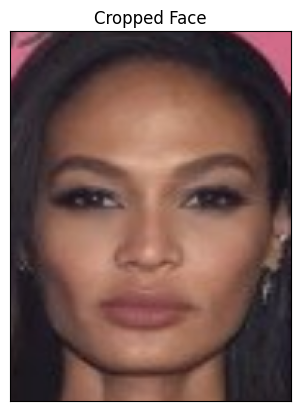

In [85]:
cropped_face = face_crop(image)

if cropped_face:
    # Convert PIL Image to numpy array
    cropped_face = np.array(cropped_face)
    
    # Reshape the array to (3, 190, 250)
    cropped_face = np.transpose(cropped_face, (2, 0, 1))
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Display the image
    # We need to transpose back for correct display
    ax.imshow(np.transpose(cropped_face, (1, 2, 0)))
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set a title
    ax.set_title("Cropped Face")
    
    # Show the plot
    plt.show()

In [60]:
def transform_image(image):
    
    transform = transforms.Compose([
        transforms.Resize((190, 250)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    return transform(image)

In [68]:
cropped_face = face_crop(image)


0: 960x736 1 face, 1088.0ms
Speed: 8.5ms preprocess, 1088.0ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 736)


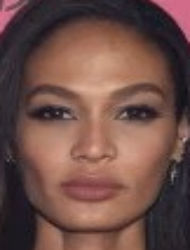

In [69]:
cropped_face

In [73]:
tensor = transform_image(cropped_face)

In [74]:
tensor.shape

torch.Size([3, 190, 250])

In [75]:
cropped_face

AttributeError: 'Image' object has no attribute 'shape'

In [ ]:
cropped_face.shape

(250, 190, 3)

In [76]:
tensor.shape

torch.Size([3, 190, 250])

In [77]:
predict_MobileNet(tensor)

('Oblong',
 {'Heart': 5.811112350784242e-05,
  'Oblong': 0.9934074878692627,
  'Oval': 0.0002546712348703295,
  'Round': 0.005493326112627983,
  'Square': 0.0006618567858822644})

In [56]:
def predict_MobileNet(image_tensor):
    # Initialize the model
    model = models.mobilenet_v3_large()
    num_features = model.classifier[3].in_features
    model.fc = nn.Linear(num_features, 5)
    model.load_state_dict(torch.load("model/mobilenet_casia_web_face_augmentation/model_MobileNetV3_Greyscal_Augment.pt", map_location=torch.device('cpu')), strict=False)
    model.eval()

    # Initialize and fit the LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(['Oblong', 'Round', 'Oval', 'Heart', 'Square'])
    model.eval()
    
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0)
        outputs = model(image_tensor)
        
        # Apply softmax to get confidence scores
        confidences = F.softmax(outputs, dim=1)
        
        # Get the predicted class index
        predicted_class_index = torch.argmax(confidences, dim=1).item()
        
        # Get the corresponding class label
        predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
        
        # Convert confidences to a list and squeeze the extra dimension
        confidence_scores = confidences.squeeze().tolist()
        
        # Get the list of class labels
        class_labels = label_encoder.classes_
        
        # Create a dictionary that maps class labels to confidence scores
        confidence_mapping = {label: score for label, score in zip(class_labels, confidence_scores)}
        
    return predicted_class_label, confidence_mapping

In [57]:
def predict_YOLO(image):
    model = YOLO('model/yolov8_imagenet/trained_yolov8x-cls_2 (1).pt')
    results = model(image)

    predicted_class_index = results[0].probs.top1
    predicted_class_name = results[0].names[predicted_class_index]

    dict = {}
    for i, prob in enumerate(results[0].probs.data.tolist()):
        dict[results[0].names[i]] = prob
    return predicted_class_name, dict

In [79]:
cropped_face = face_crop(image)


0: 960x736 1 face, 1145.1ms
Speed: 5.0ms preprocess, 1145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 960, 736)


In [81]:
predict_YOLO(cropped_face)


0: 256x256 Oblong 0.89, Square 0.11, Heart 0.00, Oval 0.00, Round 0.00, 150.2ms
Speed: 3.3ms preprocess, 150.2ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 256)


('Oblong',
 {'Heart': 0.001217468874529004,
  'Oblong': 0.8922008275985718,
  'Oval': 9.091819811146706e-05,
  'Round': 2.5151088266284205e-05,
  'Square': 0.10646563023328781})